In [1]:
import pandas as pd
from glob import glob
from collections import namedtuple, deque
import math
import itertools
import functools
from functools import reduce
from itertools import product, groupby, combinations, permutations
import numpy as np
from scipy.interpolate import UnivariateSpline
import cv2
import random
from skimage import io, morphology, img_as_bool, transform, img_as_ubyte, img_as_float, exposure, filters
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from skimage.measure import label, regionprops
from skimage.transform import probabilistic_hough_line
from scipy import stats
import copy
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split

In [2]:
def smooth_mask(mask, smooth_sigma=2):
    density = exposure.rescale_intensity(filters.gaussian(
                                                            morphology.dilation(mask, 
                                                            footprint=morphology.disk(1)), 
                                                            sigma=smooth_sigma, 
                                                            preserve_range=False), 
                                        out_range=(0, 1))
    return density

def norm_counts(counts, weights, beta=2):
    """
        This function returns a set of normalized counts, based on the weights of bins
    """
    weights = [i+beta for i in weights] # smooth
    weights = [i/ min(weights) for i in weights]
    counts_norm = [list(itertools.repeat(count, int(weight*100)))  for count, weight in zip(counts, weights)]
    return functools.reduce(lambda x1, x2 : x1+x2, counts_norm) 

def iou(mask_1, mask_2, beta=1e-3, soft=False):
    """
        This function computes a (soft) IoU of two input masks.
    """
    if soft:
        union = mask_1**2 + mask_2**2 - mask_1*mask_2
        intersection = mask_1 * mask_2
    else:
        union = np.logical_or(mask_1, mask_2)
        intersection = np.logical_and(mask_1, mask_2)
    ratio = (intersection.sum()+beta)/(union.sum()+beta)
    return ratio, union, intersection


def norm_feats(vecs):
    """
        This function normalize the features to 0-1.
    """
    vecs_1 = vecs.copy()
    for col in range(vecs_1.shape[1]):
        vecs_1[:, col] = exposure.rescale_intensity(vecs_1[:, col], out_range=(0, 1))
    return vecs_1
    

In [27]:
class CenterLine():
    def __init__(self, centerline_image=None, line_dict=None, dataframe=None, associate_image=None, image_size=None):
        self.centerline_image = img_as_float(centerline_image) if centerline_image is not None else None
        self.associate_image = img_as_float(associate_image) if associate_image is not None else None
        self.line_dict = line_dict # line_dict will always be created at initialization, line_dict > dataframe > centerlin_image
        self.linked_line_dict = None
        self.Point = namedtuple('Point', 'x y')
        self.Joint = namedtuple('Joint', 'line_ID joint_ID dir gradient')
        self.Line = namedtuple('Line', 'points head tail')
        self.Segment = namedtuple('Segment', 'point_0, point_1, length')
        if image_size is None:
            if self.centerline_image is not None:
                image_size = self.centerline_image.shape
            elif self.associate_image is not None:
                image_size = self.associate_image.shape
            else:
                image_size = (512, 512)

        if self.line_dict is not None:
            self.centerline_image = self.draw_line_dict(line_dict=self.line_dict, image_size=image_size)

        elif self.line_dict is None and self.centerline_image is not None:
            """
                Create a line_dict from the centerline_image if line_dict is not given
            """
            joints_coords, filtered_image = self.joint_filter(centerline_image) # masks have joints
            self.line_dict = self.image_to_line_dict(filtered_image)
            self.linking_fibers()
            self.line_dict = self.linked_line_dict
            self.centerline_image = self.draw_line_dict(line_dict=self.line_dict, image_size=image_size) # stored masks have joints

        elif self.line_dict is None and dataframe is not None:
            """
                Create a line_dict from the dataframe if line_dict is not given
            """
            line_dict = self.dataframe_to_lines(dataframe)
            centerline_image = self.draw_line_dict(line_dict, image_size=image_size)
            joints_coords, filtered_image = self.joint_filter(centerline_image)
            self.line_dict = self.image_to_line_dict(filtered_image)  
            self.linking_fibers()
            self.line_dict = self.linked_line_dict
            self.centerline_image = self.draw_line_dict(line_dict=self.line_dict, image_size=image_size)

        else: print("At least one of centerline_image, line_dict, and dataframe should be provided.")


    def dataframe_to_lines(self, label_csv):
        """
            This function generates a line_dict from a dataframe
        """
        line_IDs = set(label_csv.iloc[:, 0])
        line_dict = {}
        for line_ID in line_IDs:
            line_dict[str(line_ID)] = []
        for idx in range(len(label_csv)):
            line_ID = label_csv.iloc[idx, 0]
            line_coords = self.Point(label_csv.iloc[idx, 1], label_csv.iloc[idx, 2]) # x, y 
            line_dict[str(line_ID)].append(line_coords)
        for line_ID in line_IDs:
            line_dict[str(line_ID)] = self.Line(points=line_dict[str(line_ID)], head=-1, tail=-1)
        self.sort_line_dict(line_dict)
        return line_dict
        

    def image_to_line_dict(self, filtered_image):
        """
            This function takes a centerline image (joint filtered) and return a line_dict, noted that this is lossy
        """
        labeled = label(filtered_image, connectivity=2)
        regions = regionprops(labeled)
        line_dict = {}
        # return_regions = []
        for idx, region in enumerate(regions):
            if region.area<2: continue
            points = [self.Point(x=coord[1], y=coord[0]) for coord in region.coords]
            line_dict[str(idx)] = self.Line(points=points, head=-1, tail=-1)
            # return_regions.append(region)
        self.sort_line_dict(line_dict)
        return line_dict


    def joint_filter(self, image):
        """
            This function takes a centerline image (numpy array) and replace joints with 0
        """
        image = img_as_float(image)
        coords = []
        corner_tpl = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]])
        edge_tpl = np.array([[1, 0, 1], [0, 0, 0], [0, 1, 0]])
        tr_tpl = deque([1, 0, 1, 0 ,0 ,1, 0, 0])
        tr_tpls = []
        for i in range(8):
            tr_tpl.rotate(i)
            tr_tpls.append(np.asarray(tr_tpl))

        for i in range(1, image.shape[0]-1):
            for j in range(1, image.shape[1]-1):
                kernel = image[i-1:i+2, j-1:j+2]
                ks = np.count_nonzero(kernel)
                sn_kernel = np.asarray([
                    kernel[0, 0], kernel[0, 1], kernel[0, 2], kernel[1, 2], 
                    kernel[2, 2], kernel[2, 1], kernel[2, 0], kernel[1, 0]
                ])
                if kernel[1, 1] == 1:
                    if ks==6:
                        coords.append(np.asarray([i, j]))
                    elif np.count_nonzero(kernel*corner_tpl)>=3 or np.count_nonzero(kernel*edge_tpl)>=3:
                        coords.append(np.asarray([i, j]))
                    elif max([np.count_nonzero(sn_kernel*i) for i in tr_tpls])>=3:
                        coords.append(np.asarray([i, j]))
        for coord in coords:
            image[int(coord[0]), int(coord[1])] = 0
        
        return np.vstack(coords) if len(coords)>0 else np.array([]), img_as_ubyte(image)

    def sort_points(self, input_points):
        """
            This function sorts points of a line in spatial order and returns a set of sorted points
        """
        sorted_points = []
        unsorted_points = input_points
        unsorted_points = sorted(unsorted_points, key=lambda k: [k.x, k.y])
        start_point = unsorted_points.pop(0)
        sorted_points.append(start_point)
        while len(unsorted_points) > 0:
            current_start_point = sorted_points[-1]
            closest_start_idx = min(range(len(unsorted_points)), 
                key=lambda i: (unsorted_points[i].x-current_start_point.x)**2+(unsorted_points[i].y-current_start_point.y)**2)
            start_dist = (unsorted_points[closest_start_idx].x-current_start_point.x)**2+(unsorted_points[closest_start_idx].y-current_start_point.y)**2
            if len(sorted_points) < 2: 
                sorted_points.append(unsorted_points.pop(closest_start_idx))
                continue
            current_end_point = sorted_points[0]
            closest_end_idx = min(range(len(unsorted_points)), 
                key=lambda i: (unsorted_points[i].x-current_end_point.x)**2+(unsorted_points[i].y-current_end_point.y)**2)
            end_dist = (unsorted_points[closest_end_idx].x-current_end_point.x)**2+(unsorted_points[closest_end_idx].y-current_end_point.y)**2
            if start_dist <= end_dist: sorted_points.append(unsorted_points.pop(closest_start_idx))
            else: sorted_points.insert(0, unsorted_points.pop(closest_end_idx))
        return sorted_points

    def sort_line_dict(self, line_dict):
        """
            This function sorts points of all lines in a line_dict in-place
        """
        for k, v in line_dict.items():
            points = v.points
            sorted_points = self.sort_points(points)
            v = v._replace(points=sorted_points)
            line_dict[k] = v

    def draw_line(self, points, image, offset=(0, 0)):
        """
            This function draws a set of points that defines a centerline on a image (in-place)
        """
        points_x = [point.x-offset[0] for point in points]
        points_y = [point.y-offset[1] for point in points]
        points = np.vstack((points_x, points_y)).T.astype(np.int32)
        # Linear length along the line:
        # distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
        # distance = np.insert(distance, 0, 0)/distance[-1]
        # Build a list of the spline function, one for each dimension:
        if False: #points.shape[0] > 2:
            splines = [UnivariateSpline(distance, coords, k=1, s=.1) for coords in points.T]
            # Computed the spline for the asked distances:
            alpha = np.linspace(0, 1, 75)
            points_fitted = np.rint(np.vstack( spl(alpha) for spl in splines ).T).astype(np.int32)
        else:
            points_fitted = points
        points_fitted = points_fitted.reshape((-1, 1, 2)) 
        if len(image.shape) == 3:
            color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
            image = cv2.polylines(image, [points_fitted], isClosed=False, color=color, thickness=1)
        else:
            color = 225
            image = cv2.polylines(image, [points_fitted], isClosed=False, color=color, thickness=1)
        return image  


    def draw_line_dict(self, line_dict, image_size=(512, 512)):
        """
            This function draws a line_dict on an image
        """
        image = np.zeros((image_size[0], image_size[1]), np.uint8)
        for k, v in line_dict.items():
            points = v.points
            image = self.draw_line(points, image)
        image = morphology.dilation(image)
        image = img_as_ubyte(transform.resize(image, (image_size[0], image_size[1]), order=0, anti_aliasing=True))
        _, image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        image = morphology.skeletonize(img_as_bool(image))
        return image


    def line_gradient(self, line, start=-1): # -1 point backwards
        """
            This function computes the outwards angle at either end of a centerline
        """
        points_angle = lambda pt_1, pt_2 : math.atan2((pt_1.y-pt_2.y), (pt_1.x-pt_2.x)) # point to first point
        points_dist = lambda pt_1, pt_2 : math.sqrt((pt_1.x-pt_2.x)**2 + (pt_1.y-pt_2.y)**2)
        if start==1:
            line = list(reversed(line))
        angle = points_angle(line[0], line[1]) # point to first point
        if len(line)>2:
            decay = points_dist(line[0], line[1])/(points_dist(line[1], line[2])+points_dist(line[0], line[1]))
            delta_x = line[1].x + decay*(line[2].x - line[1].x) + decay**2*(line[2].x - line[0].x)
            delta_y = line[1].y + decay*(line[2].y - line[1].y) + decay**2*(line[2].y - line[0].y)
            angle = points_angle(line[0], self.Point(delta_x, delta_y))
        angle = angle * 180 / math.pi
        return angle


    def connect_lines(self, line_dict):
        """
            This function connects centerlines based on their tail/head connectivities
        """
        count = 0
        line_dict_copy = line_dict.copy()
        for k in list(line_dict_copy.keys()):
            try:
                v = line_dict_copy[k]
                if int(v.head) * int(v.tail) <= 0:
                    if int(v.head)>=0:
                        v_0 = line_dict_copy[v.head]
                        if v_0.head==k:
                            line_dict_copy[v.head] = self.Line(list(reversed(v.points))+v_0.points, head=v.tail, tail=v_0.tail)
                            del line_dict_copy[k]
                        if v_0.tail==k:
                            line_dict_copy[v.head] = self.Line(v_0.points+v.points, head=v_0.head, tail=v.tail)
                            del line_dict_copy[k]
                    if int(v.tail)>=0:
                        v_0 = line_dict_copy[v.tail]
                        if v_0.head==k:
                            line_dict_copy[v.tail] = self.Line(v.points+v_0.points, head=v.head, tail=v_0.tail)
                            del line_dict_copy[k]
                        if v_0.tail==k:
                            # print(Line(v.points+list(reversed(v_0.points)), head=v.head, tail=v_0.head))
                            line_dict_copy[v.tail] = self.Line(v.points+list(reversed(v_0.points)), head=v.head, tail=v_0.head)
                            # print(line_dict_copy)
                            del line_dict_copy[k]
            except Exception as e:
                # print(e)
                pass
        return line_dict_copy 


    def linking_fibers(self, line_dict=None, joint_thresh=3, angle_thresh=60):
        """
            This function takes joins close fragments of the line_dict and return a line_dict with linked fibers. 
            Close end points with similar incident angles will be connected.
        """
        if line_dict is None:
            line_dict = self.line_dict.copy()
        else:
            line_dict = line_dict.copy()
        end_points = [[item.points[0], item.points[-1]] for key, item in line_dict.items()]
        end_points = reduce(lambda x1, x2 : x1+x2, end_points) # flatten
        close_points = lambda pt_1, pt_2, dist_thresh : math.sqrt((pt_1.x-pt_2.x)**2 + (pt_1.y-pt_2.y)**2) < dist_thresh
        
        joints = []
        while len(end_points):
            current_point = end_points.pop() # pop one element
            
            for point in end_points:
                pop_point = close_points(current_point, point, joint_thresh) # compare to the rest
                if pop_point:
                    end_points.remove(point)
                if pop_point:
                    joints.append(current_point)
        joints = list(set(joints))

        grad_list = []
        joint_IDs = []
        for idx, joint in enumerate(joints):
            for k, v in line_dict.items():
                # print(v.points)
                if close_points(v.points[0], joint, joint_thresh):
                    angle_start = self.line_gradient(v.points, -1) # backwards
                    grad_list.append(self.Joint(k, idx, -1, angle_start))
                    joint_IDs.append(idx)
                if close_points(v.points[-1], joint, joint_thresh):
                    angle_end = self.line_gradient(v.points, 1) # forwards
                    grad_list.append(self.Joint(k, idx, 1, angle_end))
                    joint_IDs.append(idx)
        joint_IDs = list(set(joint_IDs))

        joint_dict = {}
        for joint_ID in joint_IDs:
            joint_dict[str(joint_ID)] = []
        for joint_ID in joint_IDs:
            for grad in grad_list:
                if grad.joint_ID==joint_ID:
                    joint_dict[str(joint_ID)].append(grad)
        link_dict = {}
        for k, v in joint_dict.items():
            grads = [i.gradient for i in v]
            diff = [abs(abs(i[0]-i[1])-180) for i in list(product(grads, grads))]
            result = [i for i, x in enumerate(diff) if x<angle_thresh]
            result = [frozenset((i//len(grads), i%len(grads))) for i in result]
            result = set(result)
            result = [set(i) for i in result]
            if len(result) > 1:
                pair_score = [abs(abs(grads[tuple(line_pair)[0]]-grads[tuple(line_pair)[1]])-180) for line_pair in result]
                sorted_result = [x for _, x in sorted(zip(pair_score, result))]
                running_set = set()
                pruned_result = []
                for line_pair in sorted_result:
                    if len(line_pair.intersection(running_set))==0:
                        pruned_result.append(line_pair)
                        running_set = running_set.union(line_pair)

                result = [tuple(i) for i in pruned_result]
            else:
                result = [tuple(i) for i in result]
            link_dict[k] = result

        for (k_1,v_1), (k_2,v_2) in zip(link_dict.items(), joint_dict.items()):
            for i in v_1:
                line_a = v_2[i[0]]
                line_b = v_2[i[1]]
                if line_a.dir==1: # a tail
                    line_dict[line_a.line_ID] = self.Line(line_dict[line_a.line_ID].points, head=line_dict[line_a.line_ID].head, tail=line_b.line_ID) #
                if line_a.dir==-1: # a head
                    line_dict[line_a.line_ID] = self.Line(line_dict[line_a.line_ID].points, head=line_b.line_ID, tail=line_dict[line_a.line_ID].tail)
                if line_b.dir==1: # b tail
                    line_dict[line_b.line_ID] = self.Line(line_dict[line_b.line_ID].points, head=line_dict[line_b.line_ID].head, tail=line_a.line_ID)
                if line_b.dir==-1: # b head
                    line_dict[line_b.line_ID] = self.Line(line_dict[line_b.line_ID].points, head=line_a.line_ID, tail=line_dict[line_b.line_ID].tail)

        line_dict_copy = line_dict.copy()
        heads = max([int(v.head) for k, v in line_dict_copy.items()])
        tails = max([int(v.tail) for k, v in line_dict_copy.items()])
        max_attemp = 0
        while not(heads==-1 and tails==-1):
            max_attemp += 1
            line_dict_copy = self.connect_lines(line_dict_copy)
            heads = max([int(v.head) for k, v in line_dict_copy.items()])
            tails = max([int(v.tail) for k, v in line_dict_copy.items()])
            if max_attemp > 10:
                break
        self.sort_line_dict(line_dict_copy)
        self.linked_line_dict = line_dict_copy

    def compute_feats(self, image=None, smooth_sigma=2):
        """
            This function takes a centerline image (numpy array) and return centerline features and individual fragments
        """
        # compute cirvar, cirmean, lenvar, lenmean, num_segs, alignment coefficient (normalized)
        points_dist = lambda pt_0, pt_1 : math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
        segment_angle = lambda segment : math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) #* 180 / math.pi
        if image is None:
            image = image.copy()
        else:
            image = self.image.copy()
        lines = probabilistic_hough_line(image, threshold=1, line_length=2, line_gap=0, seed=0)
        angles = []
        lengths = []
        joints, filtered = self.joint_filter(image)
        _, regions = self.image_to_line_dict(filtered)
        line_lengths = np.asarray([region.area for region in regions if region.area>3])
        for line in lines:
            p0, p1 = line # (x1, y1), (x2, y2)
            if p0[0]<=p1[0]:
                point_0 = self.Point(p0[0], p0[1])
                point_1 = self.Point(p1[0], p1[1])
            if p0[0]>p1[0]:
                point_1 = self.Point(p0[0], p0[1])
                point_0 = self.Point(p1[0], p1[1])
            segment = self.Segment(point_0, point_1, points_dist(point_0, point_1))
            angles.append(segment_angle(segment))
            lengths.append(segment.length)
            
        density = smooth_mask(image)
        if len(lines)>0:
            angles_norm = norm_counts(angles, lengths)
            cirmean = stats.circmean(angles_norm, high=math.pi/2, low=-math.pi/2)
            cirvar = stats.circvar(angles_norm, high=math.pi/2, low=-math.pi/2)
            lenmean = np.mean(line_lengths) + joints.shape[0]/np.count_nonzero(image)
            lenvar = np.var(line_lengths/lenmean)
            intensity = np.count_nonzero(image)
            feats = {'cir_mean' : cirmean, 'cir_var' : cirvar, 'len_mean' : lenmean, 'len_var' : lenvar, 'intensity' : intensity, 'density' : density}
        else:
            feats = {'cir_mean' : 1, 'cir_var' : 1, 'len_mean' : 1, 'len_var' : 1, 'intensity' : 1, 'density' : density}
        self.feats = feats
        self.regions

    def compute_fiber_feats(self, min_fiber_length=5, seg_length=4, smooth_sigma=2):
        """
            This function computes centerline features from the centerline_image
        """
        # compute cirvar, cirmean, lenvar, lenmean, num_segs, alignment coefficient (normalized)
        points_dist = lambda pt_0, pt_1 : math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
        segment_angle = lambda segment : math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) #* 180 / math.pi
        _, filtered_image = self.joint_filter(self.centerline_image)
        line_dict = self.image_to_line_dict(filtered_image)
        self.linking_fibers(line_dict)
        line_regions = []
        angles = []
        lengths = []
        full_lengths = []
        waviness = []
        single_segment = 0
        for k, v in line_dict.items():
            points = v.points
            # min_x = min([p.x for p in points])
            # min_y = min([p.y for p in points])
            # max_x = max([p.x for p in points])
            # max_y = max([p.y for p in points])
            image = np.zeros((512, 512), np.uint8)
            image = self.draw_line(points, image)
            # image = morphology.skeletonize(image)
            sub_regions = regionprops(label(image, connectivity=2))
            _, image = self.joint_filter(sub_regions[0].image)
            labeled = label(image, connectivity=2)
            regions = regionprops(labeled)
            line_regions.extend(regions)
        line_regions = [i for i in line_regions if i.area>=min_fiber_length]
        for region in line_regions:   
            # fragments = probabilistic_hough_line(region.image, threshold=1, line_length=2, line_gap=0, seed=0)
            # region_image = np.pad(region, (1, 1))
            points = [centerline.Point(point[1]+1, point[0]+1) for point in region.coords]
            points = self.sort_points(points)
            shape_line = LineString([(point.x, point.y) for point in points])
            num_seg = int(np.ceil(shape_line.length/seg_length))
            split_points = [int(i*seg_length) for i in range(1, num_seg)]
            splitter = MultiPoint([shape_line.interpolate(i) for i in split_points])
            if len(splitter) < 1:
                num_seg = int( np.ceil( shape_line.length/max(1, seg_length-2) ) )
                split_points = [int(i*max(1, seg_length-2)) for i in range(1, num_seg)]
                splitter = MultiPoint([shape_line.interpolate(i) for i in split_points]) 
            fragments = split(shape_line, splitter)
            # compute waviness
            seg_angles = []
            seg_lengths = []
            for fragment in fragments:
                # p0, p1 = fragment # (x1, y1), (x2, y2)
                sx, sy = fragment.coords.xy[0][0], fragment.coords.xy[1][0]
                ex, ey = fragment.coords.xy[0][-1], fragment.coords.xy[1][-1]
                # if sx <= ex:
                point_0 = self.Point(sx, sy)
                point_1 = self.Point(ex, ey)
                # if sx > ex:
                    # point_1 = self.Point(sx, sy)
                    # point_0 = self.Point(ex, ey)
                seg = self.Segment(point_0, point_1, points_dist(point_0, point_1))
                seg_angle = segment_angle(seg)
                seg_length = seg.length
                seg_angles.append(seg_angle)
                seg_lengths.append(seg_length)
                # for computing global attribute
                angles.append(seg_angle)
                lengths.append(seg_length)
            full_lengths.append(region.area)
            if len(seg_angles) > 1:
                seg_angles = norm_counts(seg_angles, seg_lengths)
                waviness.append(stats.circvar(seg_angles, high=math.pi/2, low=-math.pi/2))
            else:
                single_segment += 1
                waviness.append(0)
            
        if smooth_sigma > 0: density = smooth_mask(self.centerline_image, smooth_sigma=smooth_sigma)
        else: density = self.centerline_image
        if len(waviness)>0:
            angles_norm = norm_counts(angles, lengths)
            cirmean = stats.circmean(angles_norm, high=math.pi/2, low=-math.pi/2)
            cirvar = stats.circvar(angles_norm, high=math.pi/2, low=-math.pi/2)
            lenmean = np.mean(full_lengths)
            # lenvar = np.var(exposure.rescale_intensity(np.vstack(lengths), out_range=(0, 1)))
            lenvar = np.std(full_lengths)
            intensity = np.count_nonzero(self.centerline_image)
            waviness = np.mean(np.asarray(waviness)) * (len(lengths) + single_segment)/len(lengths)
            feats = {
                'cir_mean' : cirmean, 'cir_var' : cirvar, 'len_mean' : lenmean, 'len_var' : lenvar, 
                'waviness' : waviness, 'intensity' : intensity, 'density' : density
                }
        else:
            feats = {
                'cir_mean' : -1, 'cir_var' : -1, 'len_mean' : -1, 'len_var' : -1,
                'waviness' : -1, 'intensity' : -1, 'density' : density}
        self.feats = feats
        self.regions = line_regions

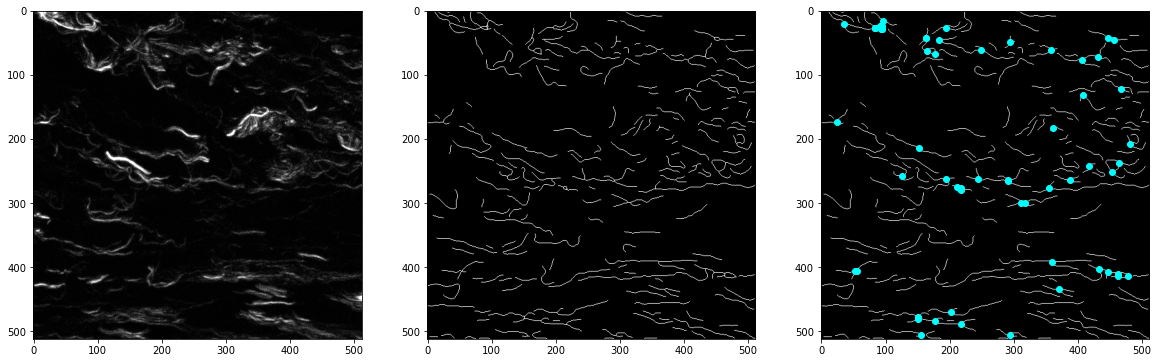

In [28]:
# create centerline from masks
centerline = CenterLine(centerline_image=io.imread("example_centerline.png"), associate_image=io.imread("example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

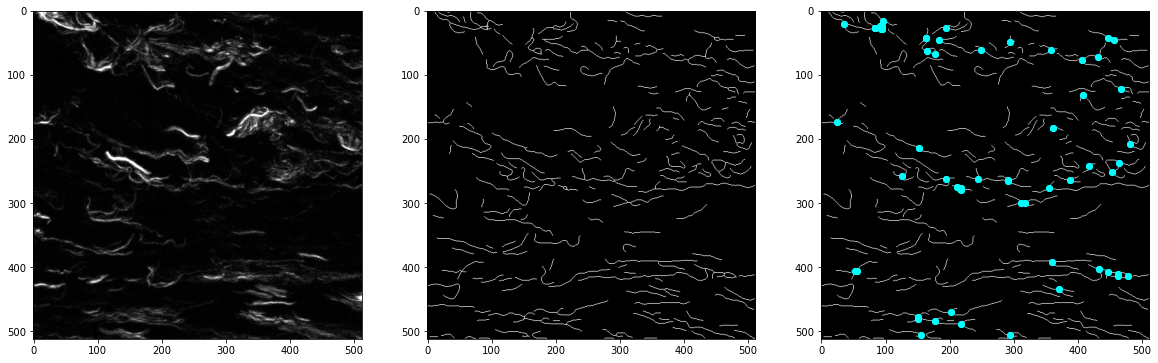

In [29]:
# create centerline from dataframe
centerline = CenterLine(dataframe=pd.read_csv("example_annotations.csv", index_col=0), associate_image=io.imread("example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

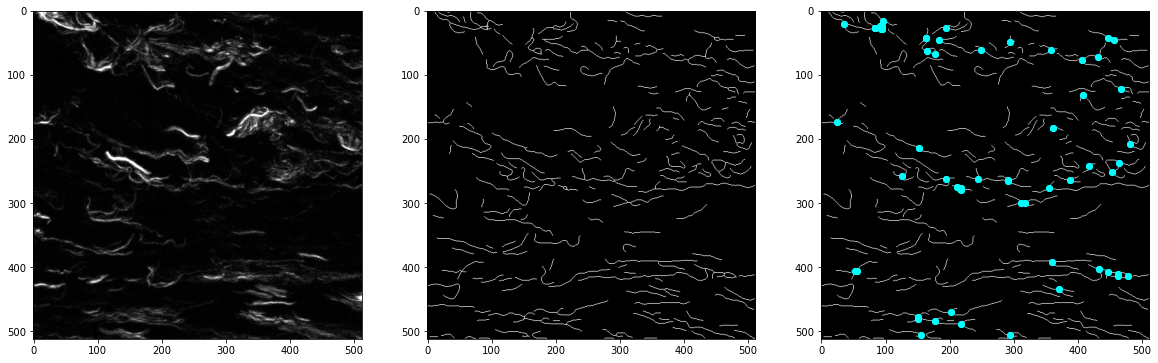

In [30]:
# create centerline from line_dict object
line_dict = centerline.line_dict
centerline = CenterLine(line_dict=line_dict, associate_image=io.imread("example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

In [31]:
### compute centerline features, example using centerline_image
centerline = CenterLine(centerline_image=io.imread("example_centerline.png"), associate_image=io.imread("example_image.tif")) # joints are NOT broken by default
centerline.compute_fiber_feats() 
print(centerline.feats)

{'cir_mean': 0.09844431875480075, 'cir_var': 0.28623102594221633, 'len_mean': 35.05, 'len_var': 28.705119119006696, 'waviness': 0.17722242346602532, 'intensity': 7789, 'density': array([[0.00000000e+00, 1.31350121e-05, 1.52563358e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.48839187e-05, 1.54940108e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.31350121e-05, 1.30400793e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.40149222e-02, 8.09045146e-02, 1.58691565e-01, ...,
        5.71384307e-01, 5.32496967e-01, 4.95396219e-01],
       [2.42596351e-02, 5.79699632e-02, 1.14203925e-01, ...,
        7.48074808e-01, 7.33518498e-01, 7.08760211e-01],
       [1.38045454e-02, 3.32272409e-02, 6.59031556e-02, ...,
        8.77616666e-01, 8.94105602e-01, 8.87972000e-01]])}


In [32]:
### compute centerline features, example using dataframe
centerline = CenterLine(dataframe=pd.read_csv("example_annotations.csv", index_col=0), associate_image=io.imread("example_image.tif"))
centerline.compute_fiber_feats() 
print(centerline.feats)

{'cir_mean': 0.09933172494444364, 'cir_var': 0.2860967210889133, 'len_mean': 34.88235294117647, 'len_var': 28.678191153859984, 'waviness': 0.17720396772681019, 'intensity': 7787, 'density': array([[0.00000000e+00, 1.31350121e-05, 1.52563358e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.48839187e-05, 1.54940108e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.31350121e-05, 1.30400793e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.40149222e-02, 8.09045146e-02, 1.58691565e-01, ...,
        5.71384307e-01, 5.32496967e-01, 4.95396219e-01],
       [2.42596351e-02, 5.79699632e-02, 1.14203925e-01, ...,
        7.48074808e-01, 7.33518498e-01, 7.08760211e-01],
       [1.38045454e-02, 3.32272409e-02, 6.59031556e-02, ...,
        8.77616666e-01, 8.94105602e-01, 8.87972000e-01]])}


In [14]:
### currently, breaking joints + linking fiber is lossy, safest way is to work with all masks

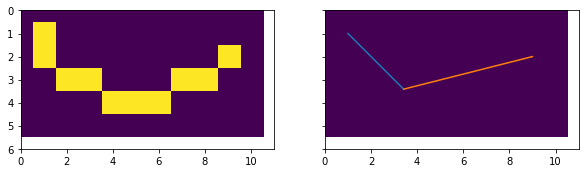

Length: 10.00, Waveiness: 0.3137 



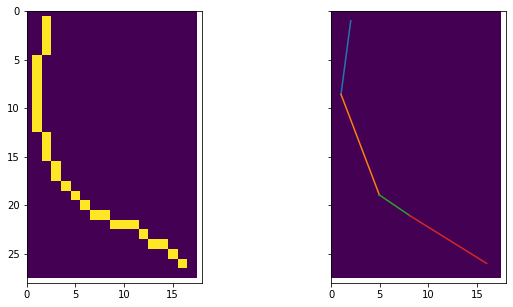

Length: 30.00, Waveiness: 0.2371 



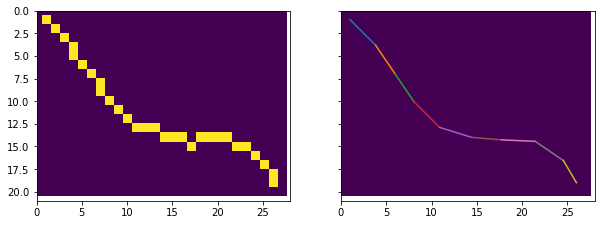

Length: 29.00, Waveiness: 0.1381 



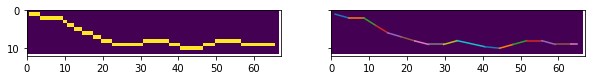

Length: 65.00, Waveiness: 0.0605 



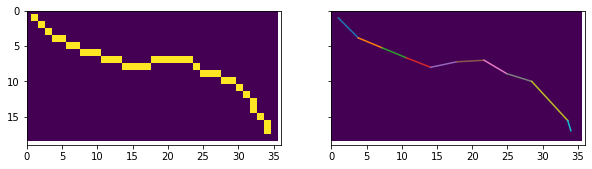

Length: 36.00, Waveiness: 0.1487 



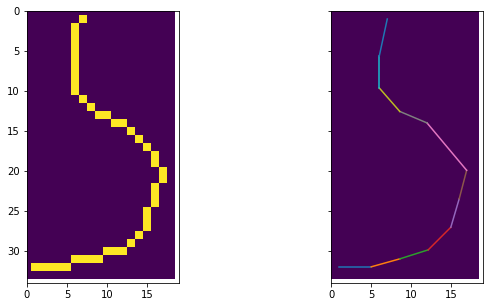

Length: 43.00, Waveiness: 1.3031 



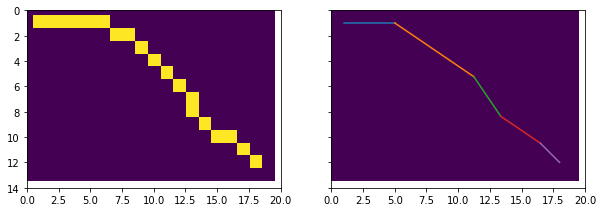

Length: 19.00, Waveiness: 0.0995 



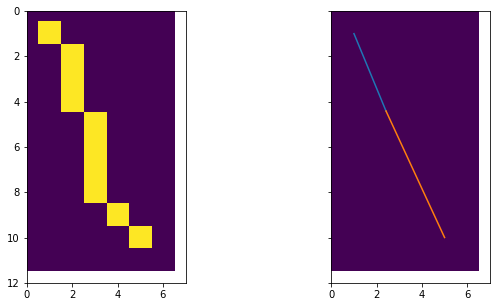

Length: 10.00, Waveiness: 0.0004 



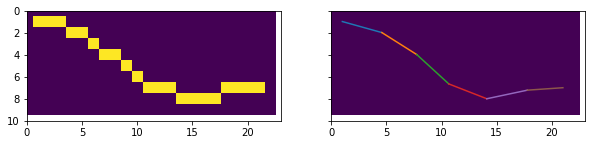

Length: 21.00, Waveiness: 0.1169 



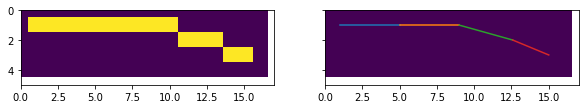

Length: 15.00, Waveiness: 0.0285 



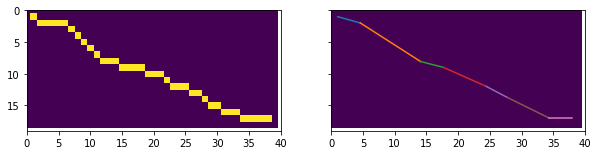

Length: 38.00, Waveiness: 0.0286 



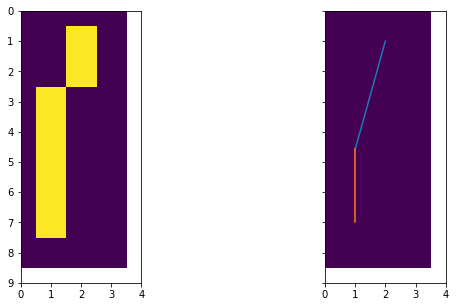

Length: 7.00, Waveiness: 0.0184 



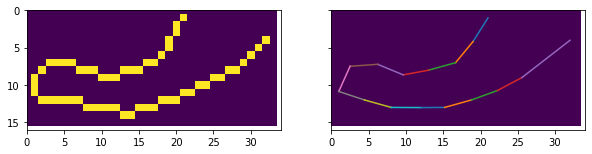

Length: 56.00, Waveiness: 0.2213 



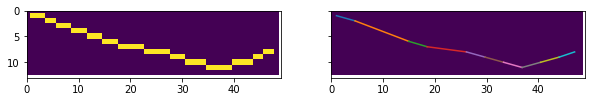

Length: 47.00, Waveiness: 0.0632 



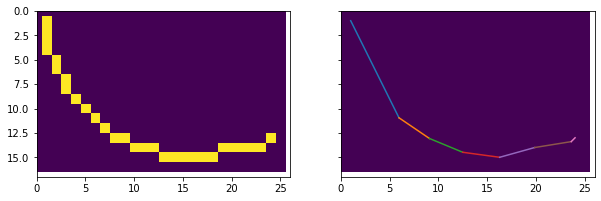

Length: 29.00, Waveiness: 0.3996 



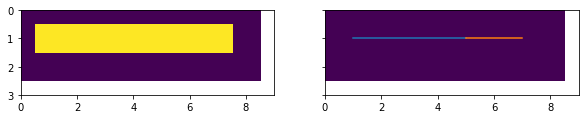

Length: 7.00, Waveiness: -0.0000 



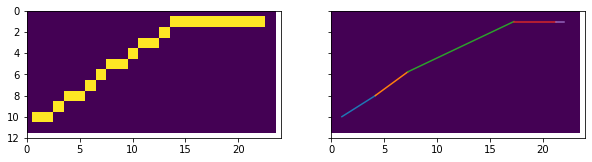

Length: 22.00, Waveiness: 0.0569 



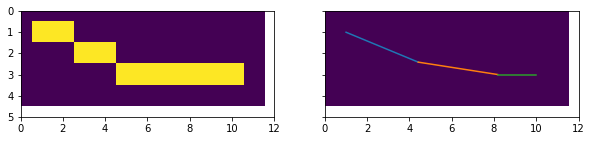

Length: 10.00, Waveiness: 0.0249 



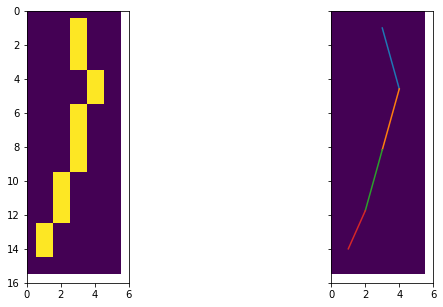

Length: 14.00, Waveiness: 0.0713 



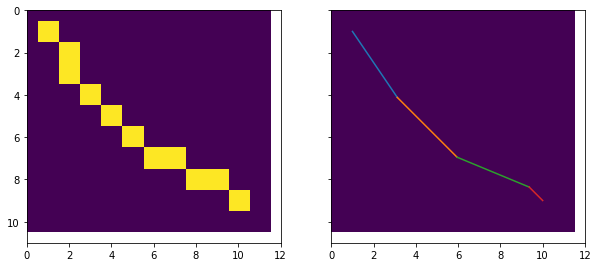

Length: 11.00, Waveiness: 0.0510 



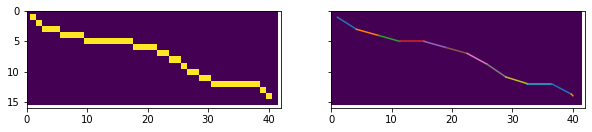

Length: 40.00, Waveiness: 0.0445 



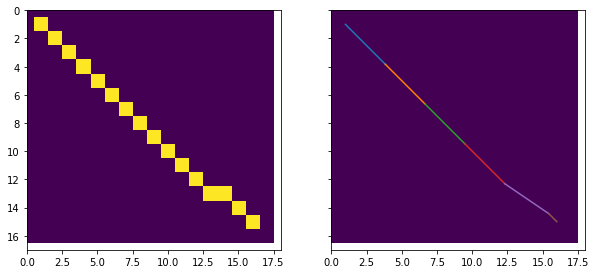

Length: 16.00, Waveiness: 0.0052 



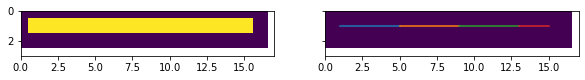

Length: 15.00, Waveiness: -0.0000 



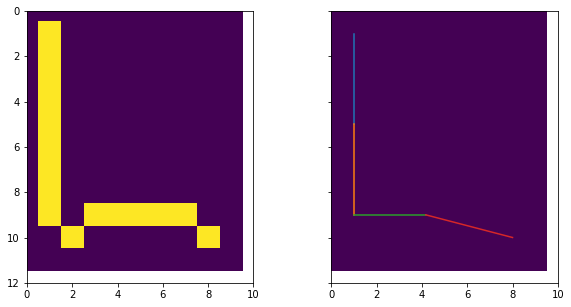

Length: 16.00, Waveiness: 0.9675 



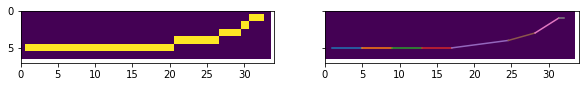

Length: 32.00, Waveiness: 0.0340 



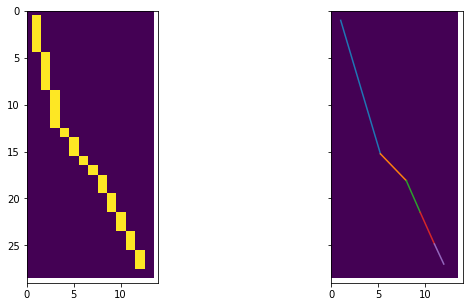

Length: 27.00, Waveiness: 0.0260 



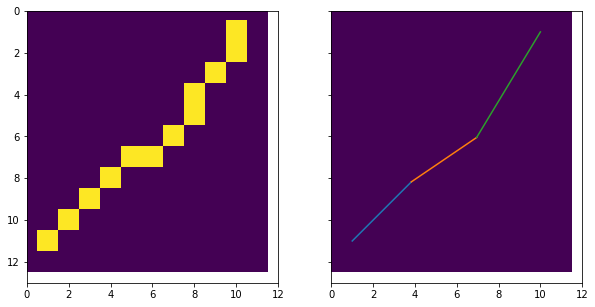

Length: 12.00, Waveiness: 0.0328 



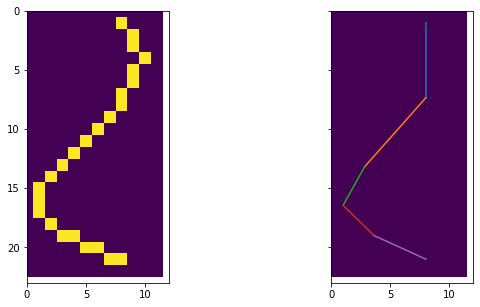

Length: 24.00, Waveiness: 0.7095 



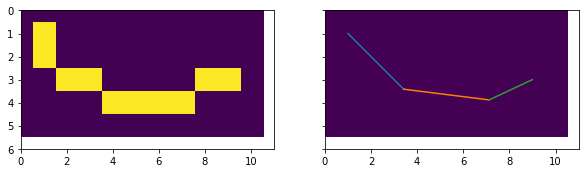

Length: 10.00, Waveiness: 0.2649 



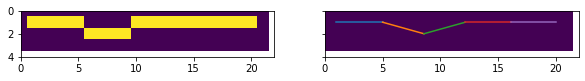

Length: 20.00, Waveiness: 0.0292 



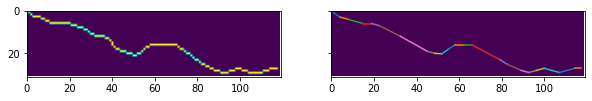

Length: 118.00, Waveiness: 0.1122 



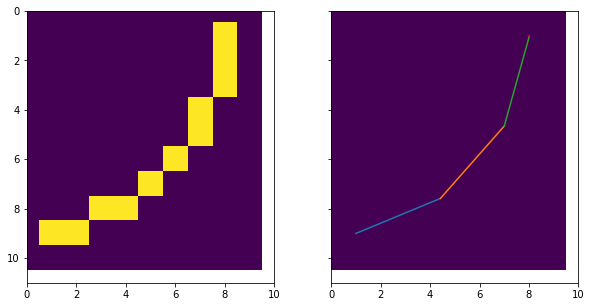

Length: 11.00, Waveiness: 0.1863 



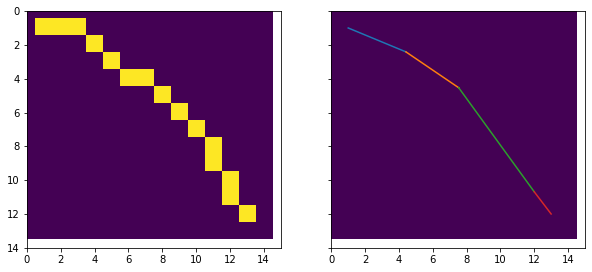

Length: 15.00, Waveiness: 0.0548 



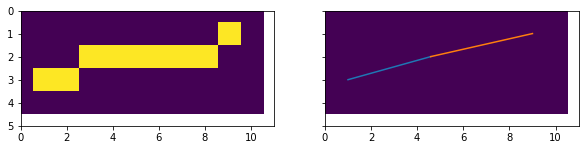

Length: 9.00, Waveiness: 0.0006 



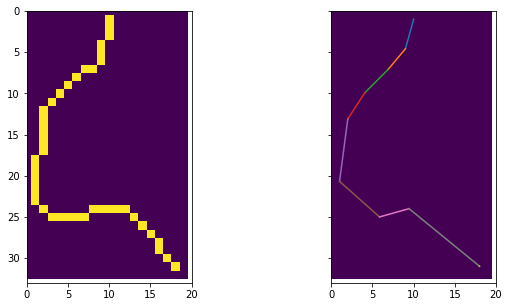

Length: 42.00, Waveiness: 0.9548 



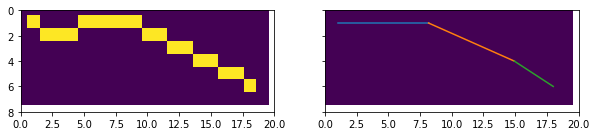

Length: 18.00, Waveiness: 0.0593 



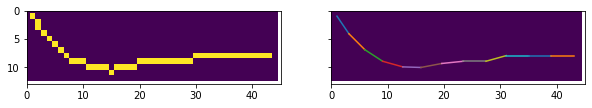

Length: 44.00, Waveiness: 0.1460 



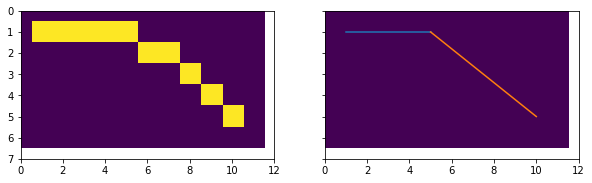

Length: 10.00, Waveiness: 0.1193 



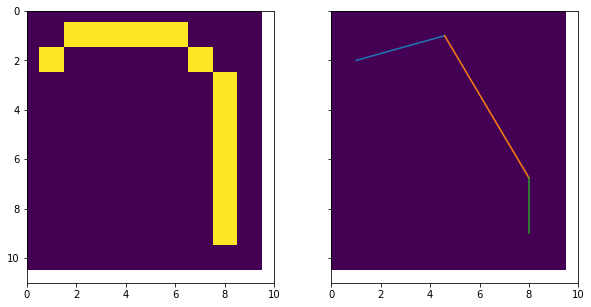

Length: 14.00, Waveiness: 0.5788 



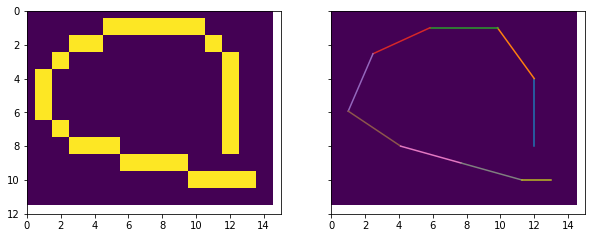

Length: 31.00, Waveiness: 0.5685 



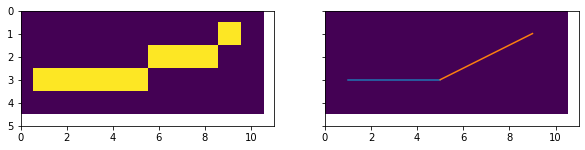

Length: 9.00, Waveiness: 0.0557 



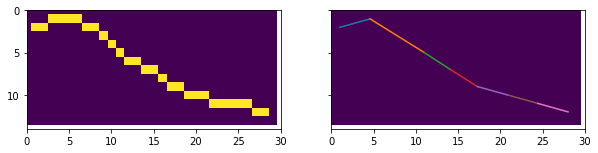

Length: 28.00, Waveiness: 0.0731 



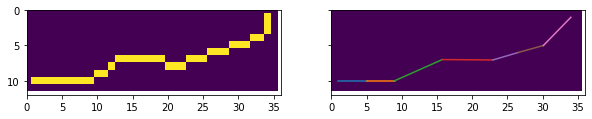

Length: 36.00, Waveiness: 0.0797 



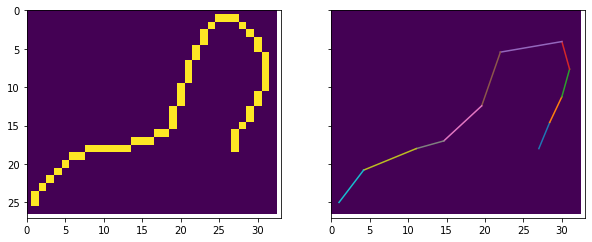

Length: 53.00, Waveiness: 0.2654 



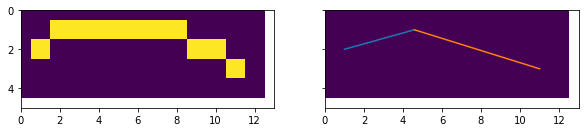

Length: 11.00, Waveiness: 0.0830 



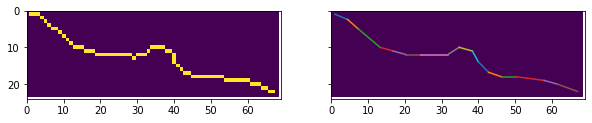

Length: 69.00, Waveiness: 0.1278 



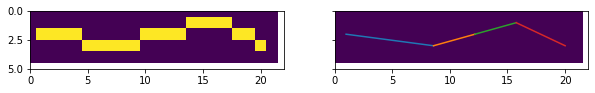

Length: 20.00, Waveiness: 0.0851 



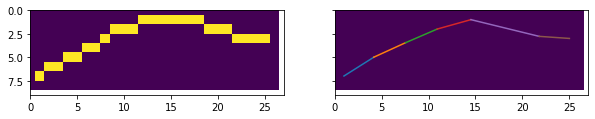

Length: 25.00, Waveiness: 0.0990 



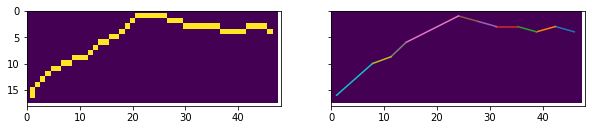

Length: 47.00, Waveiness: 0.1753 



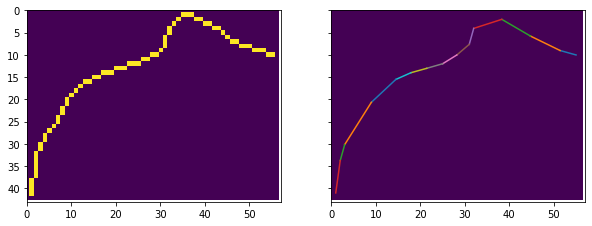

Length: 71.00, Waveiness: 0.4780 



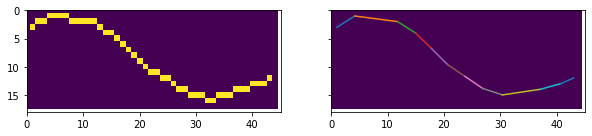

Length: 43.00, Waveiness: 0.2244 



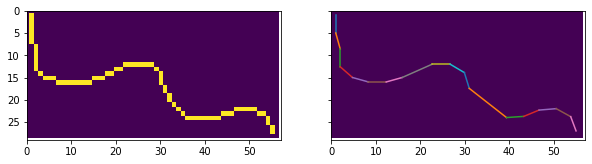

Length: 72.00, Waveiness: 0.5384 



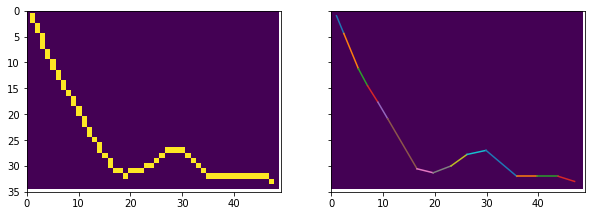

Length: 61.00, Waveiness: 0.4148 



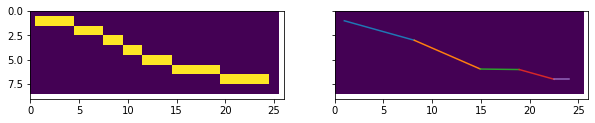

Length: 24.00, Waveiness: 0.0236 



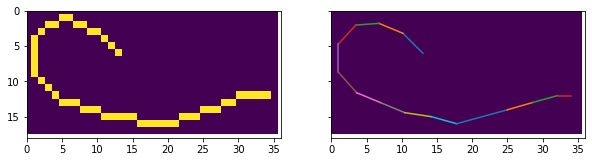

Length: 51.00, Waveiness: 0.3142 



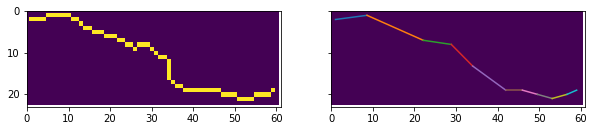

Length: 63.00, Waveiness: 0.1278 



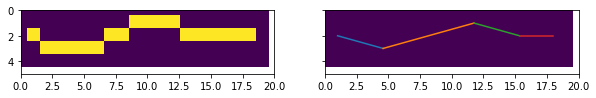

Length: 18.00, Waveiness: 0.0622 



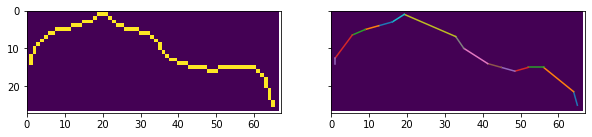

Length: 74.00, Waveiness: 0.4298 



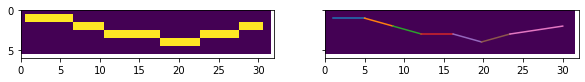

Length: 30.00, Waveiness: 0.0425 



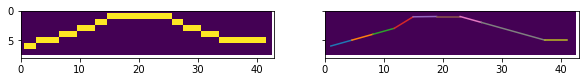

Length: 41.00, Waveiness: 0.0736 



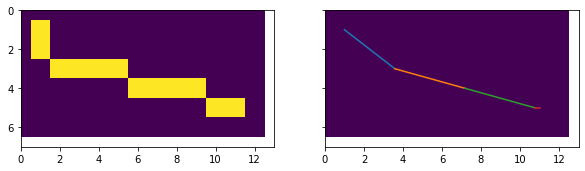

Length: 12.00, Waveiness: 0.0451 



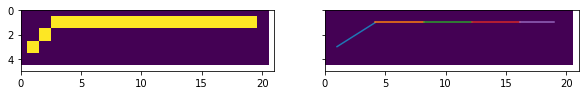

Length: 19.00, Waveiness: 0.0505 



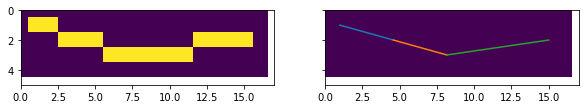

Length: 15.00, Waveiness: 0.0441 



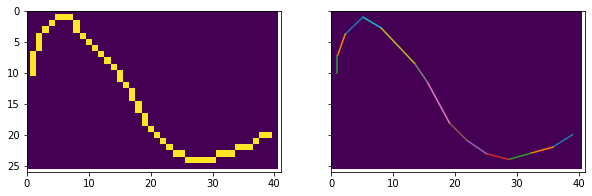

Length: 49.00, Waveiness: 0.6556 



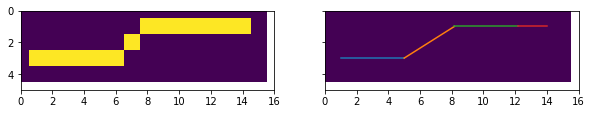

Length: 14.00, Waveiness: 0.0630 



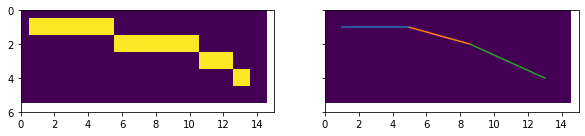

Length: 13.00, Waveiness: 0.0320 



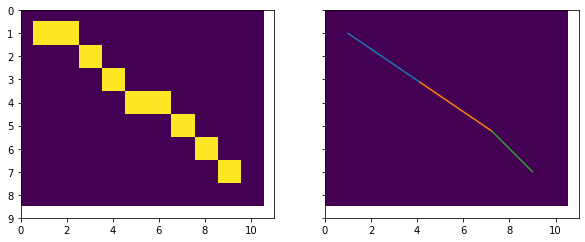

Length: 9.00, Waveiness: 0.0072 



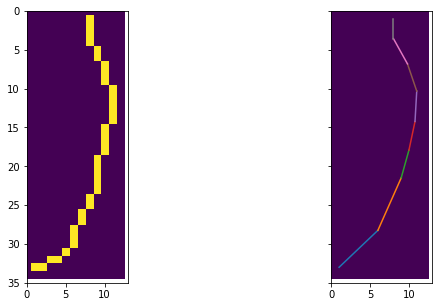

Length: 35.00, Waveiness: 0.1729 



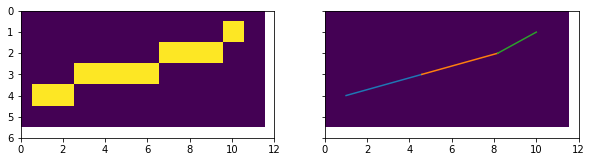

Length: 10.00, Waveiness: 0.0102 



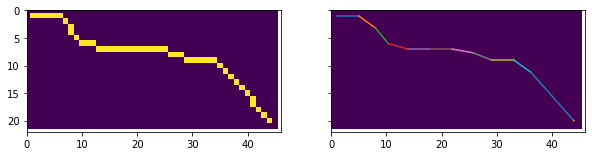

Length: 46.00, Waveiness: 0.1324 



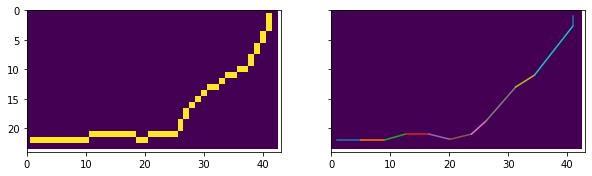

Length: 48.00, Waveiness: 0.2351 



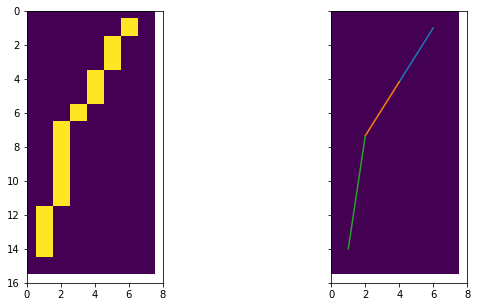

Length: 14.00, Waveiness: 0.0431 



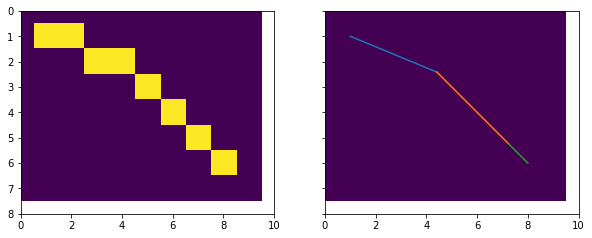

Length: 8.00, Waveiness: 0.0373 



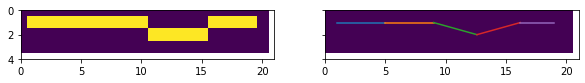

Length: 19.00, Waveiness: 0.0300 



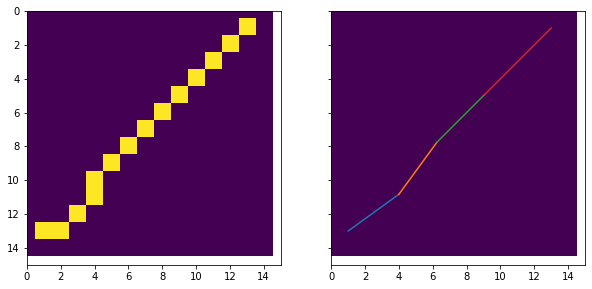

Length: 14.00, Waveiness: 0.0113 



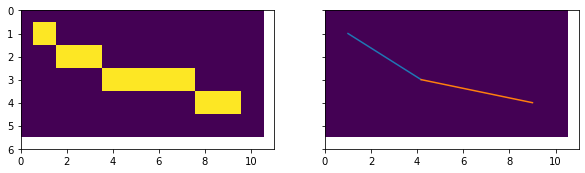

Length: 9.00, Waveiness: 0.0325 



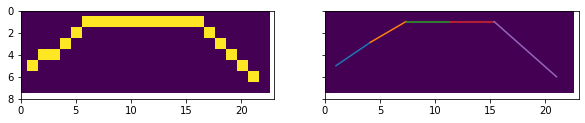

Length: 21.00, Waveiness: 0.3003 



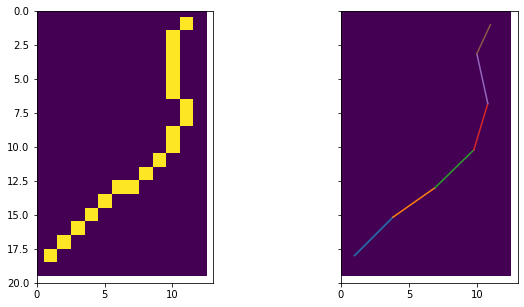

Length: 19.00, Waveiness: 0.1683 



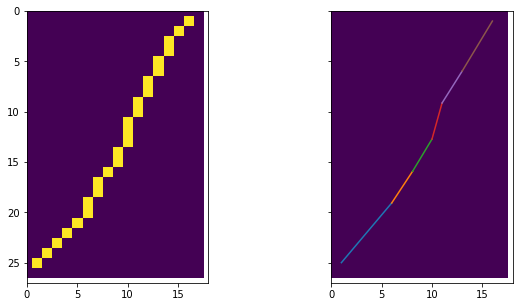

Length: 25.00, Waveiness: 0.0165 



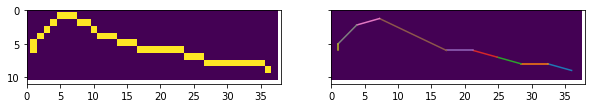

Length: 37.00, Waveiness: 0.2009 



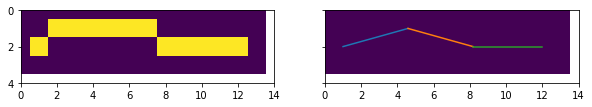

Length: 12.00, Waveiness: 0.0504 



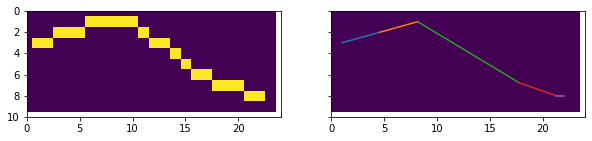

Length: 22.00, Waveiness: 0.1406 



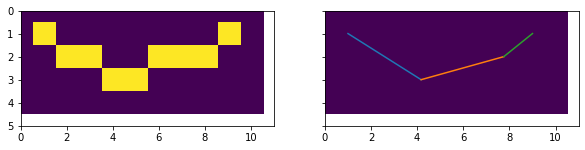

Length: 9.00, Waveiness: 0.3011 



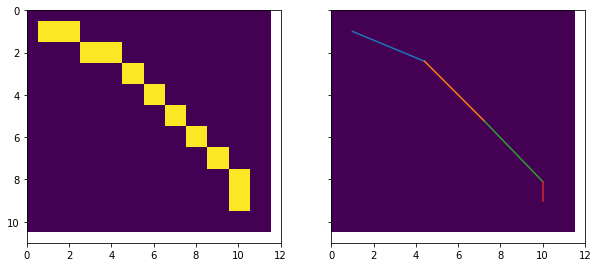

Length: 11.00, Waveiness: 0.1252 



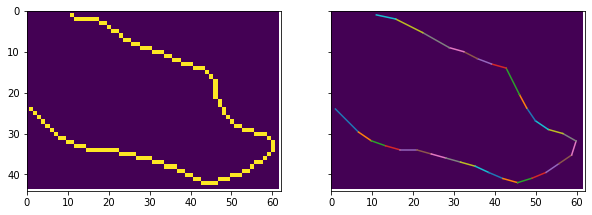

Length: 117.00, Waveiness: 0.1990 



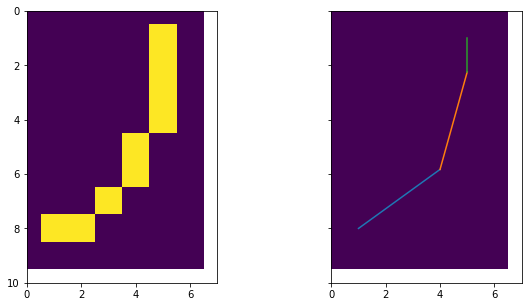

Length: 9.00, Waveiness: 0.1662 



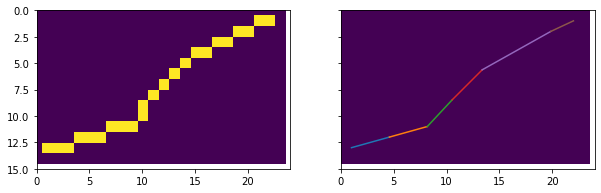

Length: 23.00, Waveiness: 0.0459 



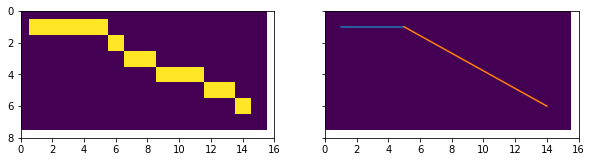

Length: 14.00, Waveiness: 0.0584 



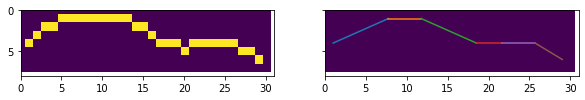

Length: 29.00, Waveiness: 0.1196 



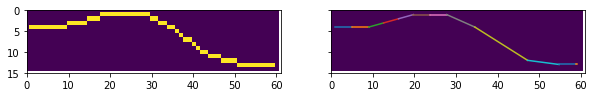

Length: 59.00, Waveiness: 0.0879 



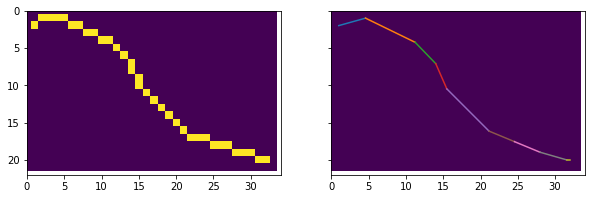

Length: 34.00, Waveiness: 0.1481 



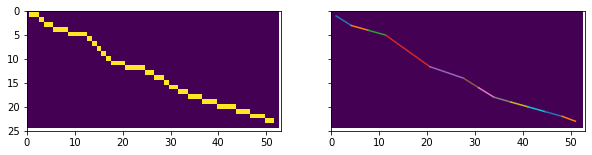

Length: 51.00, Waveiness: 0.0216 



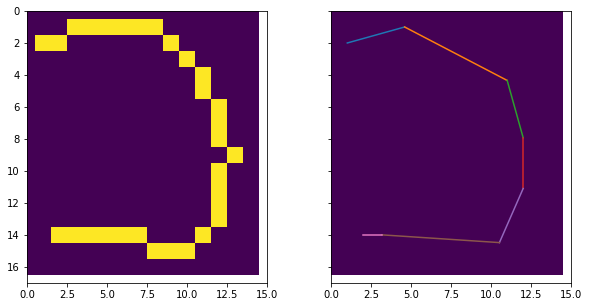

Length: 30.00, Waveiness: 0.7492 



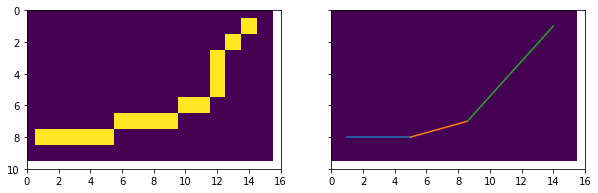

Length: 16.00, Waveiness: 0.1449 



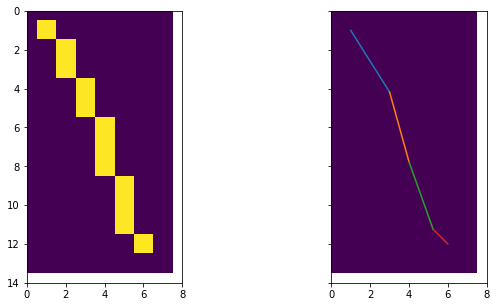

Length: 12.00, Waveiness: 0.0332 



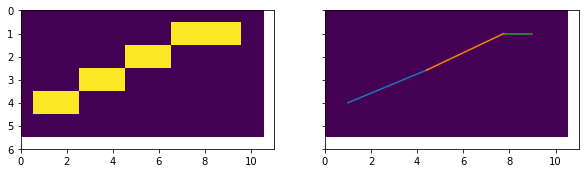

Length: 9.00, Waveiness: 0.0307 



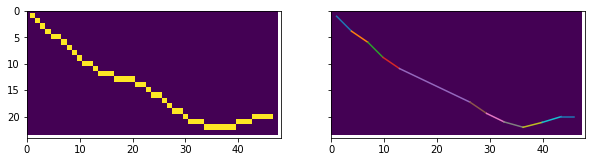

Length: 46.00, Waveiness: 0.1161 



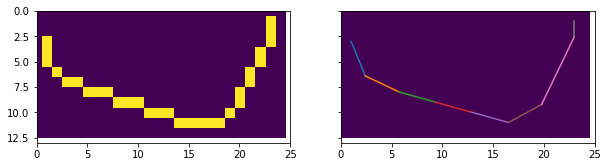

Length: 30.00, Waveiness: 0.8056 



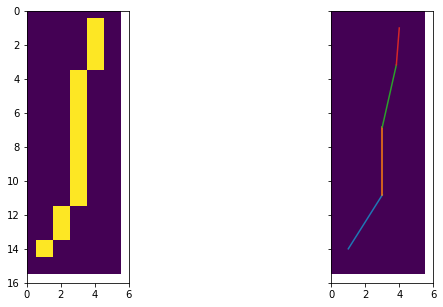

Length: 14.00, Waveiness: 0.0493 



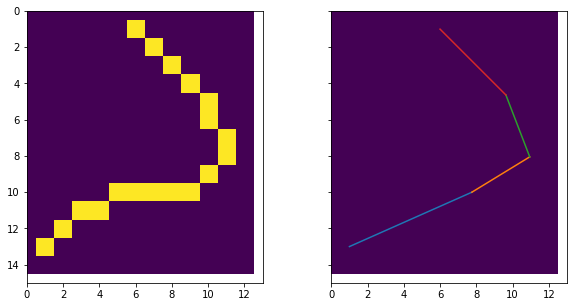

Length: 18.00, Waveiness: 0.8754 



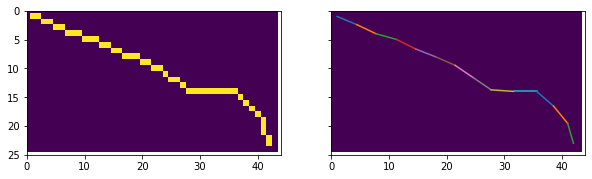

Length: 45.00, Waveiness: 0.1024 



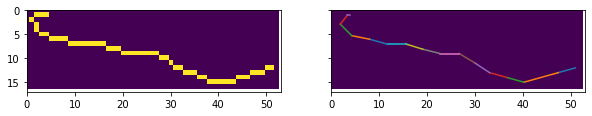

Length: 55.00, Waveiness: 0.1383 



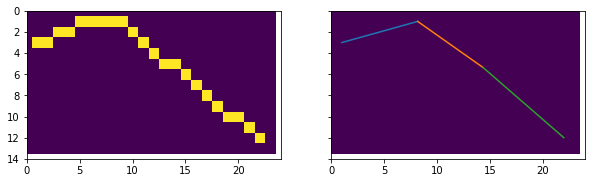

Length: 22.00, Waveiness: 0.2043 



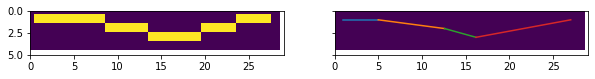

Length: 27.00, Waveiness: 0.0301 



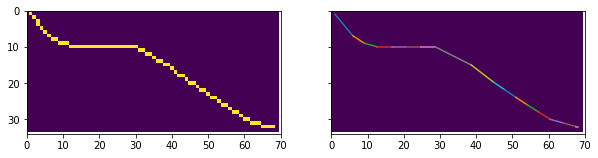

Length: 69.00, Waveiness: 0.0793 



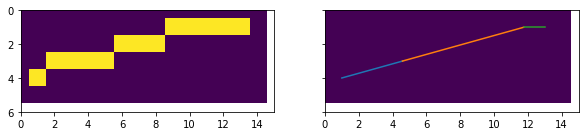

Length: 13.00, Waveiness: 0.0107 



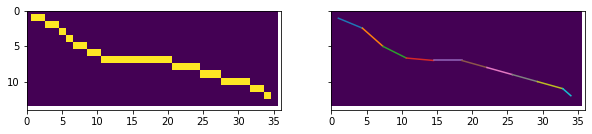

Length: 34.00, Waveiness: 0.0479 



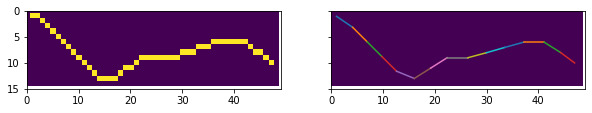

Length: 47.00, Waveiness: 0.2873 



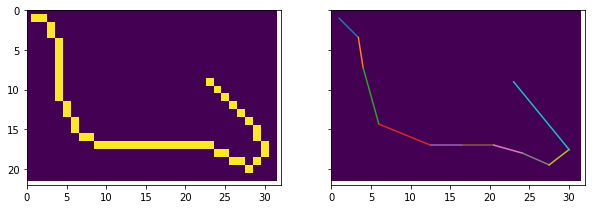

Length: 49.00, Waveiness: 0.3487 



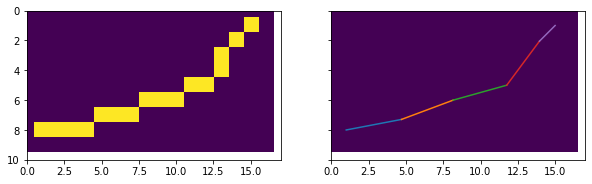

Length: 16.00, Waveiness: 0.0913 



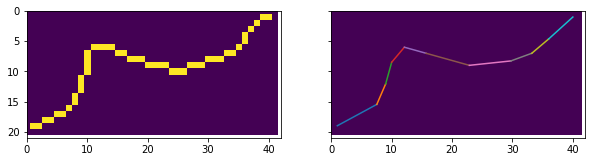

Length: 47.00, Waveiness: 0.2901 



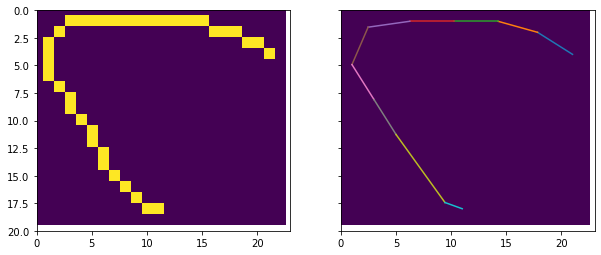

Length: 37.00, Waveiness: 0.3624 



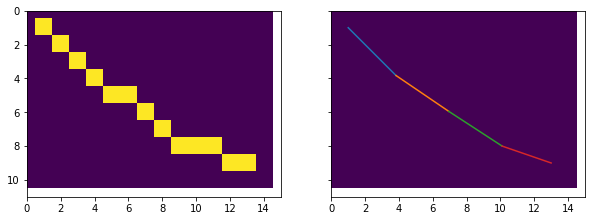

Length: 13.00, Waveiness: 0.0253 



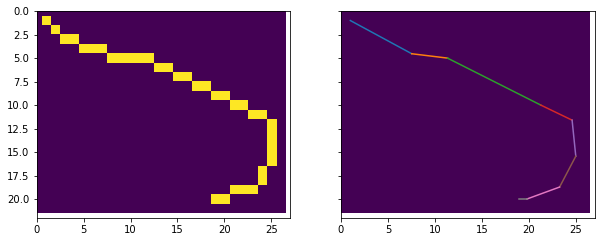

Length: 36.00, Waveiness: 0.3560 



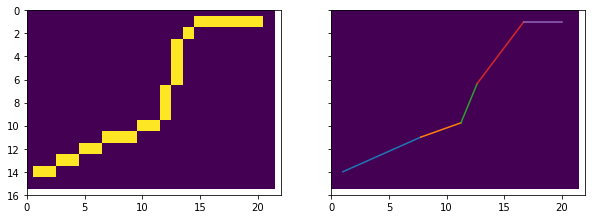

Length: 25.00, Waveiness: 0.1677 



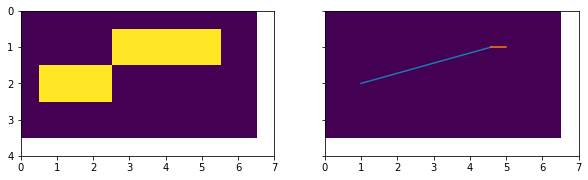

Length: 5.00, Waveiness: 0.0155 



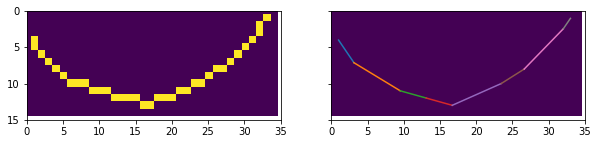

Length: 35.00, Waveiness: 0.5089 



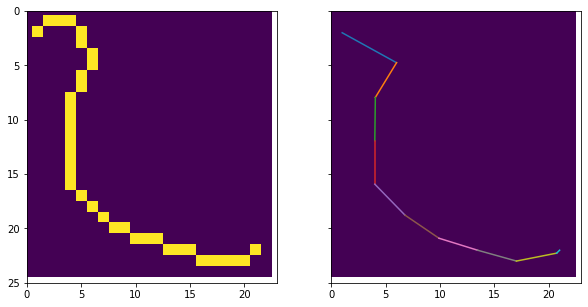

Length: 36.00, Waveiness: 0.6449 



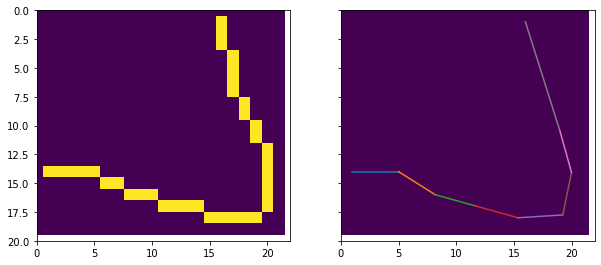

Length: 36.00, Waveiness: 0.5233 



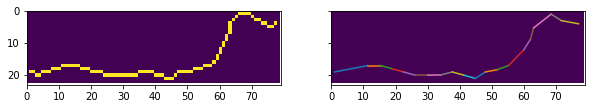

Length: 84.00, Waveiness: 0.2323 



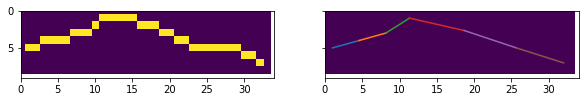

Length: 32.00, Waveiness: 0.1141 



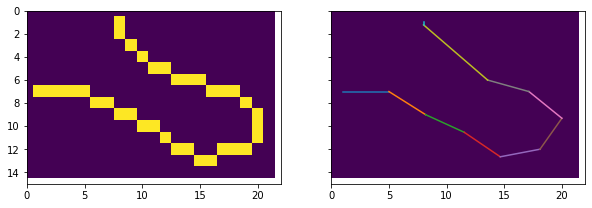

Length: 35.00, Waveiness: 0.2530 



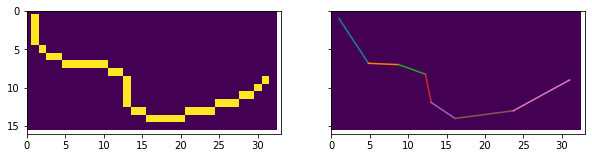

Length: 37.00, Waveiness: 0.4662 



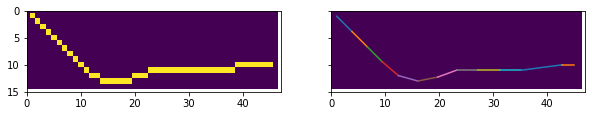

Length: 45.00, Waveiness: 0.1834 



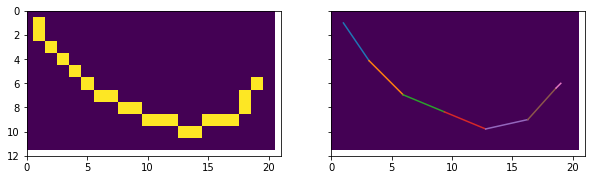

Length: 21.00, Waveiness: 0.4929 



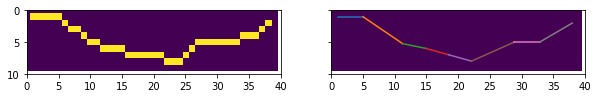

Length: 38.00, Waveiness: 0.1575 



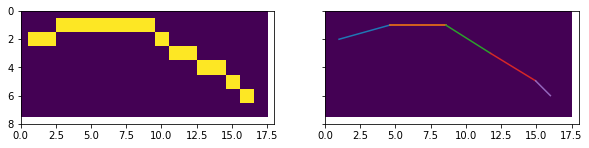

Length: 16.00, Waveiness: 0.1621 



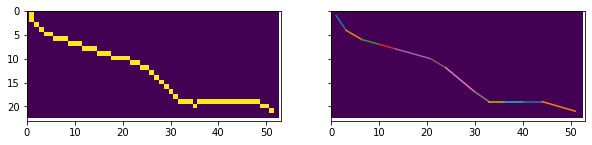

Length: 52.00, Waveiness: 0.0809 



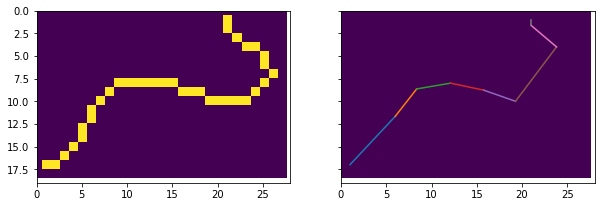

Length: 35.00, Waveiness: 0.5400 



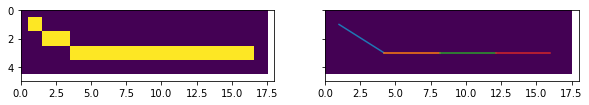

Length: 16.00, Waveiness: 0.0590 



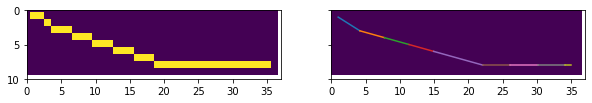

Length: 35.00, Waveiness: 0.0327 



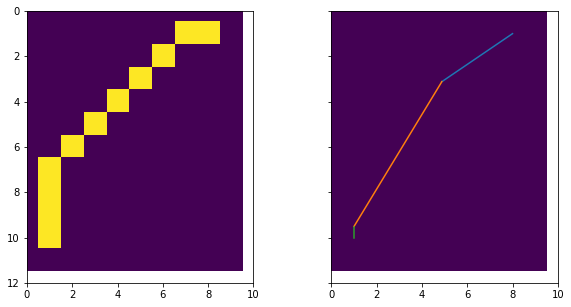

Length: 11.00, Waveiness: 0.0985 



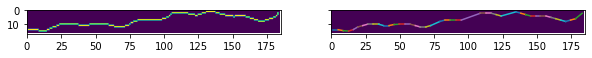

Length: 184.00, Waveiness: 0.0664 



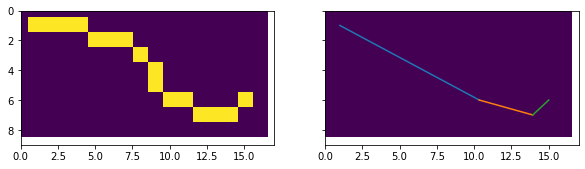

Length: 16.00, Waveiness: 0.1638 



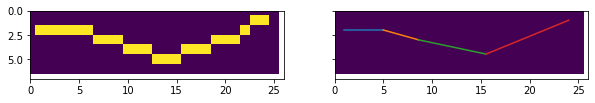

Length: 24.00, Waveiness: 0.0809 



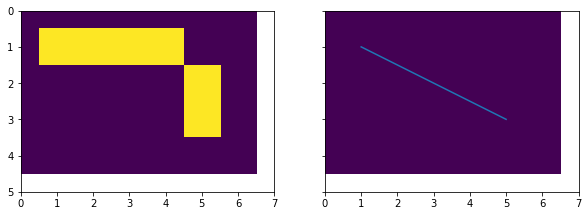

Length: 6.00, Waveiness: 0.0809 



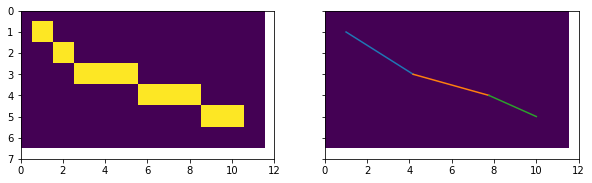

Length: 10.00, Waveiness: 0.0153 



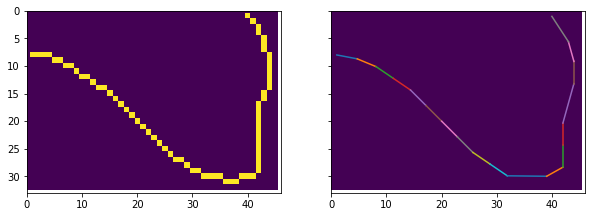

Length: 70.00, Waveiness: 0.3885 



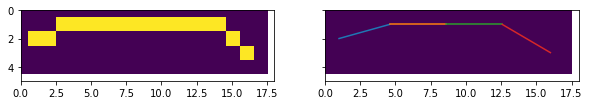

Length: 16.00, Waveiness: 0.0864 



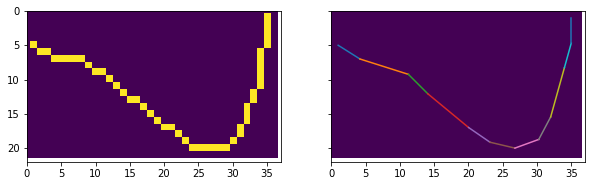

Length: 48.00, Waveiness: 0.7133 



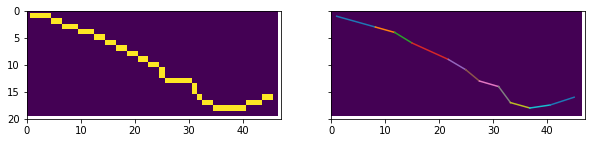

Length: 47.00, Waveiness: 0.1061 



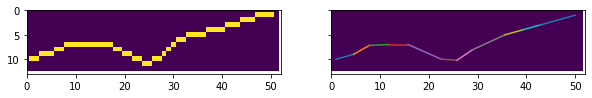

Length: 50.00, Waveiness: 0.0861 



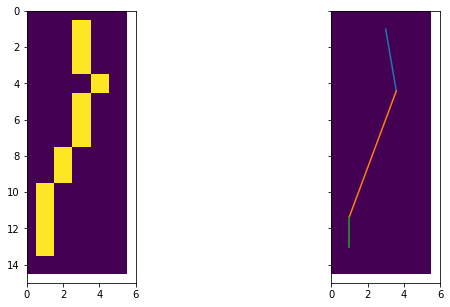

Length: 13.00, Waveiness: 0.0580 



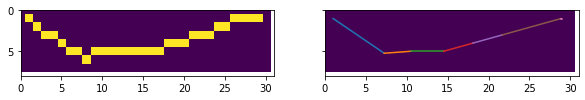

Length: 29.00, Waveiness: 0.1148 



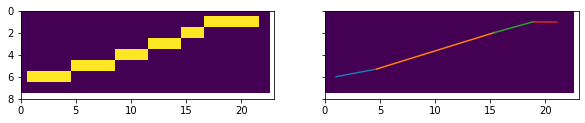

Length: 21.00, Waveiness: 0.0105 



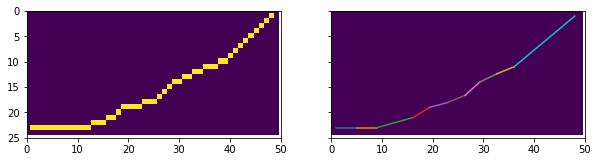

Length: 48.00, Waveiness: 0.0631 



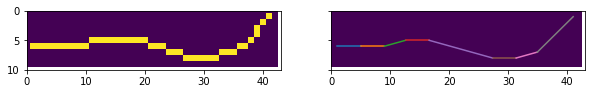

Length: 42.00, Waveiness: 0.1239 



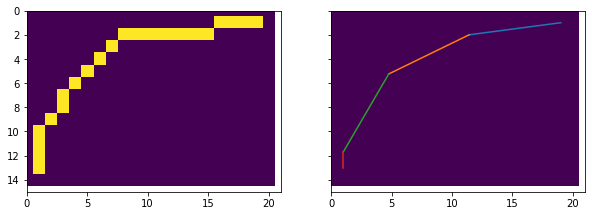

Length: 23.00, Waveiness: 0.2453 



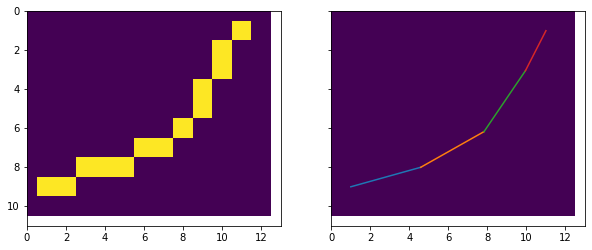

Length: 13.00, Waveiness: 0.1172 



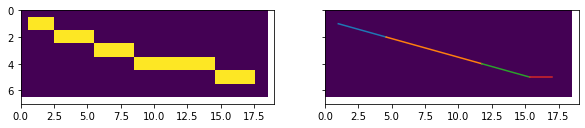

Length: 17.00, Waveiness: 0.0093 



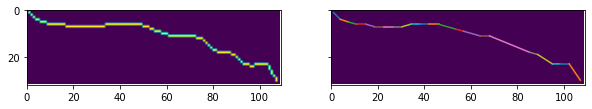

Length: 110.00, Waveiness: 0.0861 



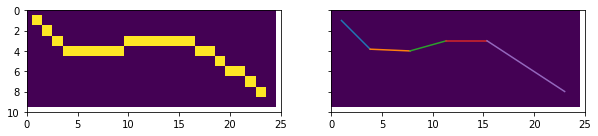

Length: 23.00, Waveiness: 0.1586 



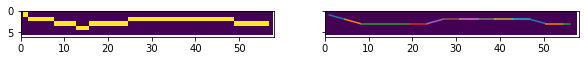

Length: 56.00, Waveiness: 0.0192 



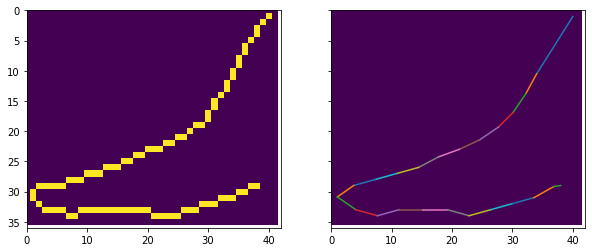

Length: 85.00, Waveiness: 0.1812 



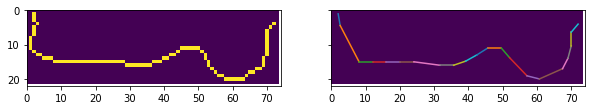

Length: 93.00, Waveiness: 0.6418 



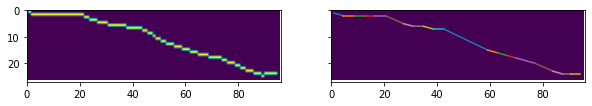

Length: 94.00, Waveiness: 0.0311 



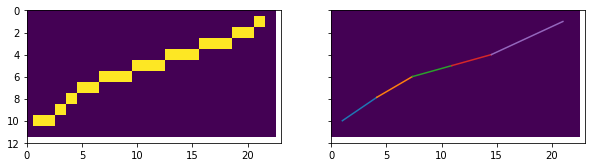

Length: 21.00, Waveiness: 0.0157 



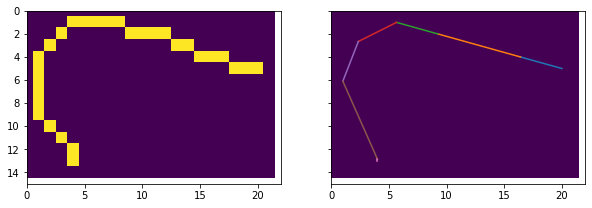

Length: 29.00, Waveiness: 0.6167 



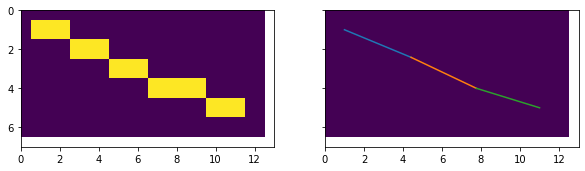

Length: 11.00, Waveiness: 0.0035 



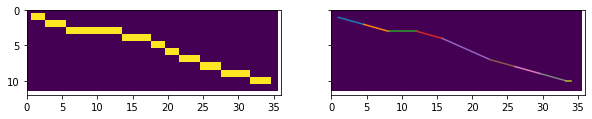

Length: 34.00, Waveiness: 0.0157 



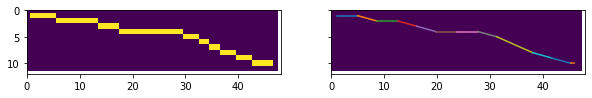

Length: 46.00, Waveiness: 0.0242 



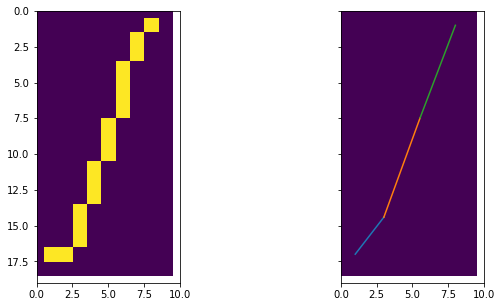

Length: 18.00, Waveiness: 0.0158 



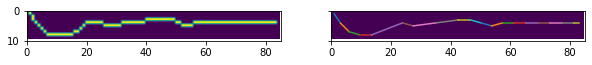

Length: 84.00, Waveiness: 0.0972 



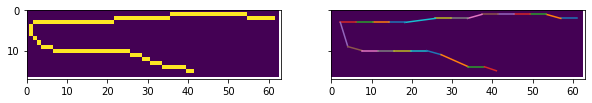

Length: 103.00, Waveiness: 0.0773 



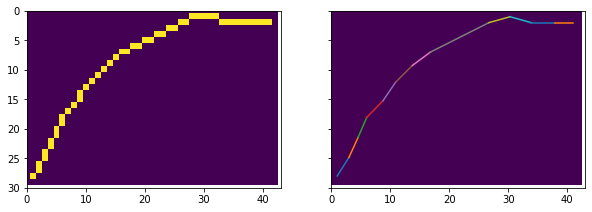

Length: 47.00, Waveiness: 0.2077 



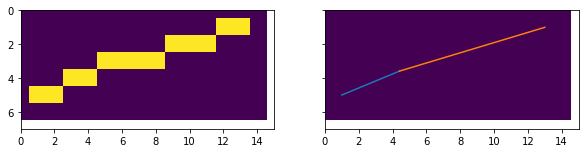

Length: 13.00, Waveiness: 0.0023 



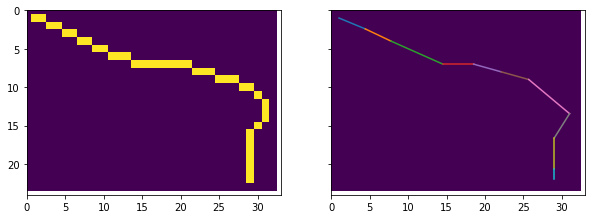

Length: 41.00, Waveiness: 0.3388 



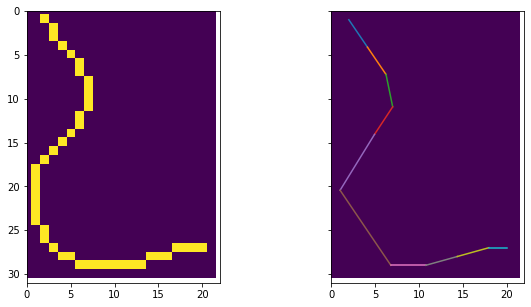

Length: 44.00, Waveiness: 1.3092 



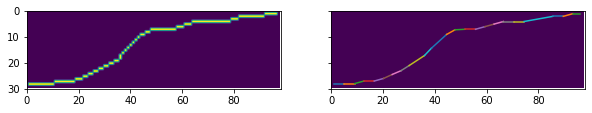

Length: 97.00, Waveiness: 0.0661 



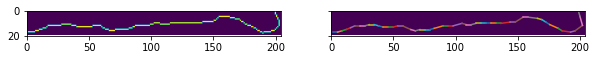

Length: 213.00, Waveiness: 0.1332 



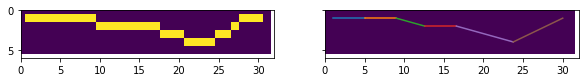

Length: 30.00, Waveiness: 0.0704 



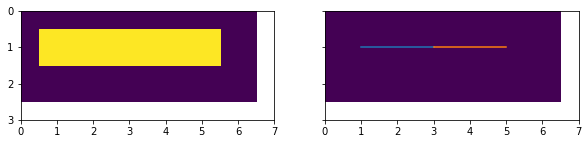

Length: 5.00, Waveiness: -0.0000 



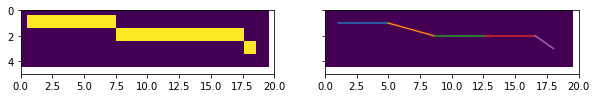

Length: 18.00, Waveiness: 0.0470 



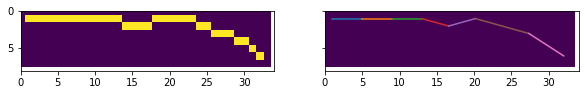

Length: 32.00, Waveiness: 0.0656 



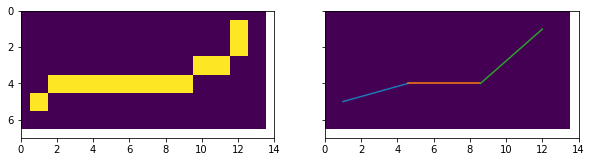

Length: 13.00, Waveiness: 0.0960 



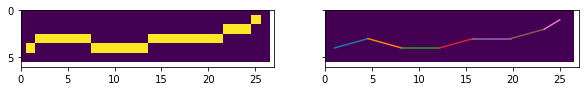

Length: 25.00, Waveiness: 0.0559 



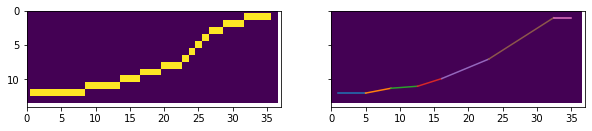

Length: 35.00, Waveiness: 0.0473 



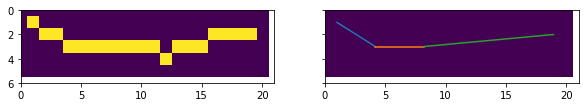

Length: 19.00, Waveiness: 0.0665 



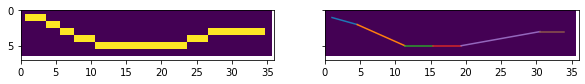

Length: 34.00, Waveiness: 0.0505 



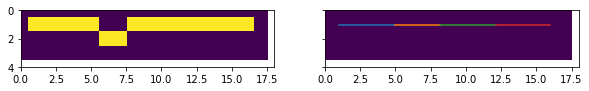

Length: 16.00, Waveiness: -0.0000 



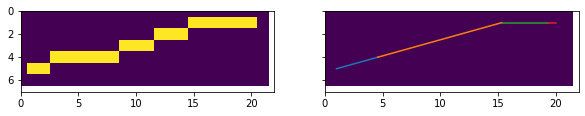

Length: 20.00, Waveiness: 0.0160 



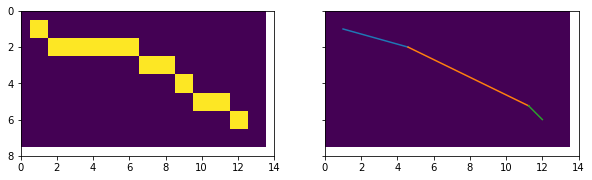

Length: 12.00, Waveiness: 0.0290 



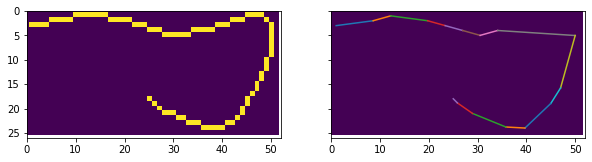

Length: 87.00, Waveiness: 0.3214 



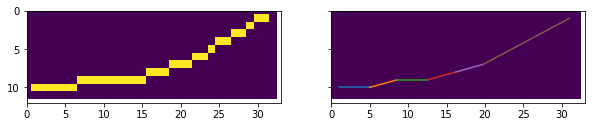

Length: 31.00, Waveiness: 0.0367 



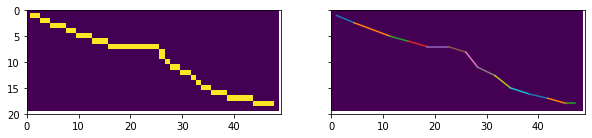

Length: 48.00, Waveiness: 0.0492 



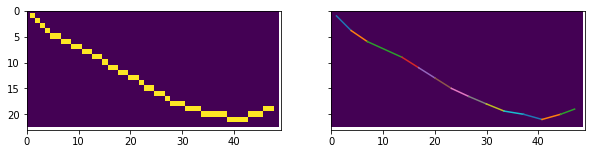

Length: 47.00, Waveiness: 0.0910 



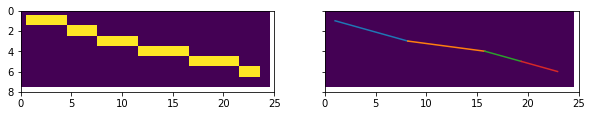

Length: 23.00, Waveiness: 0.0071 



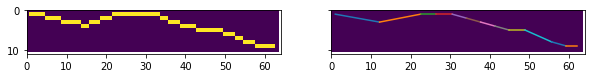

Length: 62.00, Waveiness: 0.0357 



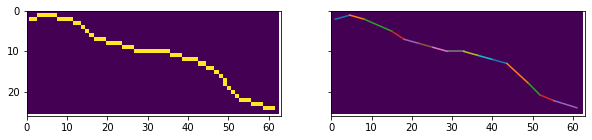

Length: 62.00, Waveiness: 0.0635 



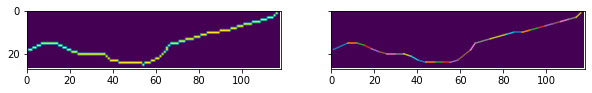

Length: 117.00, Waveiness: 0.1197 



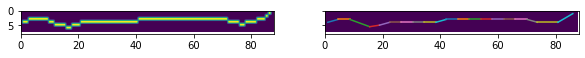

Length: 86.00, Waveiness: 0.0390 



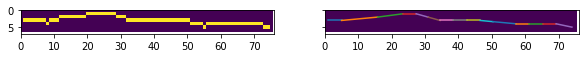

Length: 74.00, Waveiness: 0.0139 



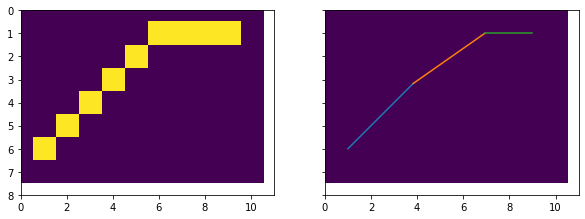

Length: 9.00, Waveiness: 0.1018 



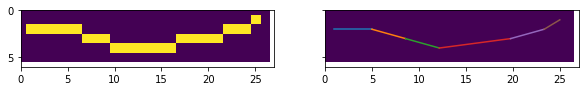

Length: 25.00, Waveiness: 0.0695 



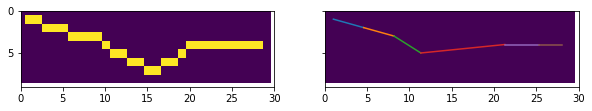

Length: 28.00, Waveiness: 0.0540 



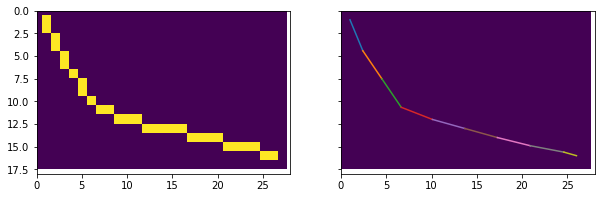

Length: 30.00, Waveiness: 0.1504 



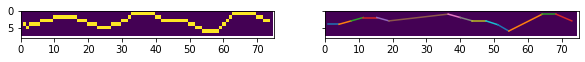

Length: 73.00, Waveiness: 0.0845 



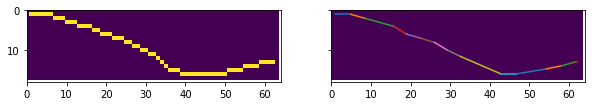

Length: 62.00, Waveiness: 0.0725 



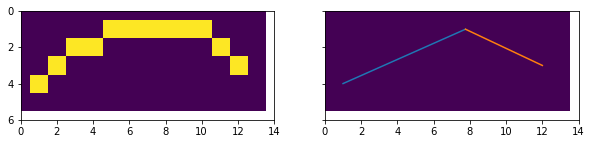

Length: 12.00, Waveiness: 0.2034 



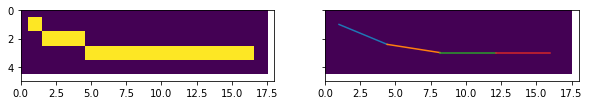

Length: 16.00, Waveiness: 0.0259 



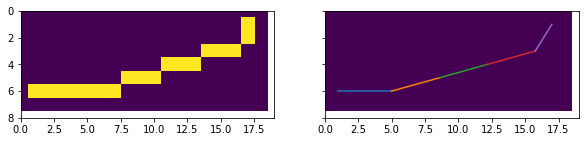

Length: 18.00, Waveiness: 0.0964 



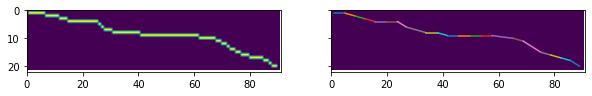

Length: 89.00, Waveiness: 0.0379 



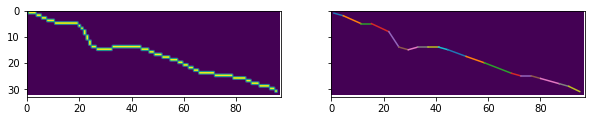

Length: 98.00, Waveiness: 0.0609 



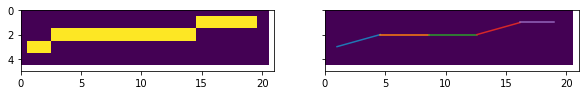

Length: 19.00, Waveiness: 0.0180 



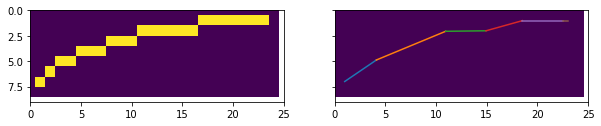

Length: 23.00, Waveiness: 0.0509 



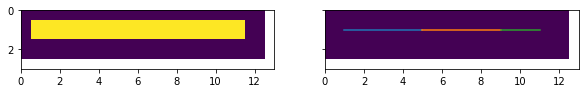

Length: 11.00, Waveiness: -0.0000 



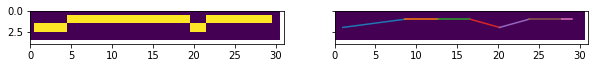

Length: 29.00, Waveiness: 0.0230 



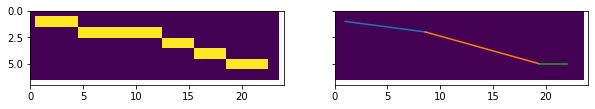

Length: 22.00, Waveiness: 0.0104 



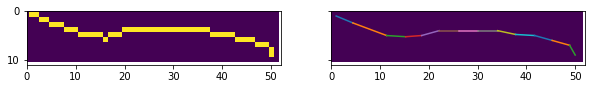

Length: 51.00, Waveiness: 0.0735 



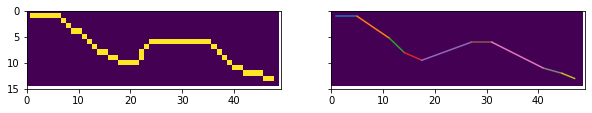

Length: 48.00, Waveiness: 0.1319 



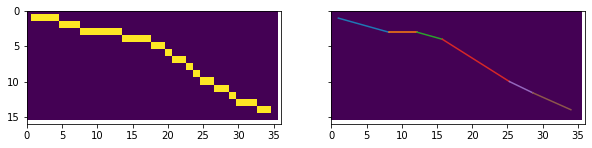

Length: 34.00, Waveiness: 0.0316 



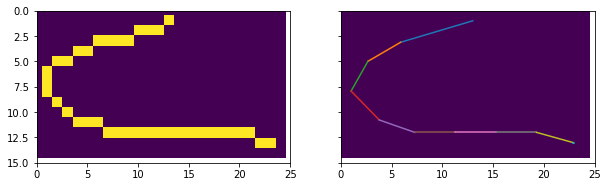

Length: 37.00, Waveiness: 0.2203 



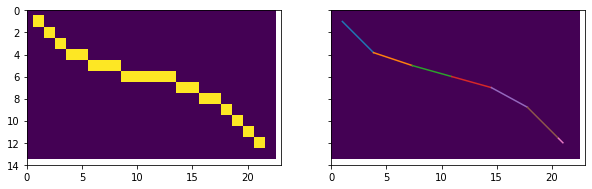

Length: 21.00, Waveiness: 0.0539 



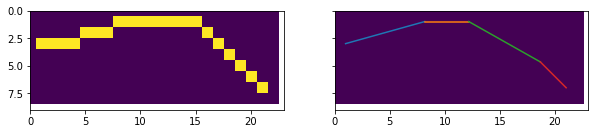

Length: 21.00, Waveiness: 0.1870 



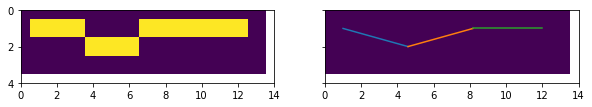

Length: 12.00, Waveiness: 0.0504 



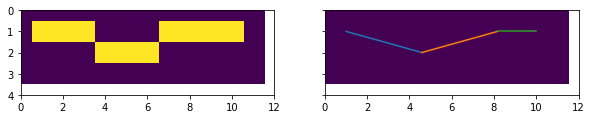

Length: 10.00, Waveiness: 0.0572 



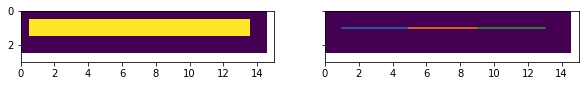

Length: 13.00, Waveiness: -0.0000 



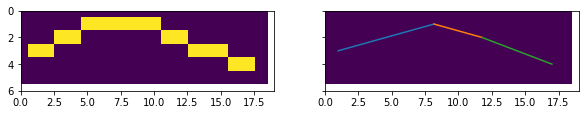

Length: 17.00, Waveiness: 0.0928 



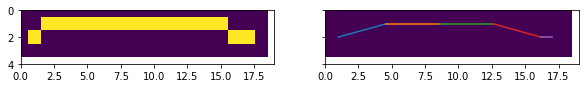

Length: 17.00, Waveiness: 0.0324 



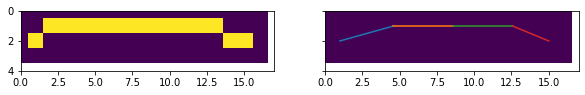

Length: 15.00, Waveiness: 0.0512 



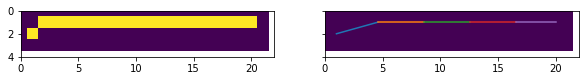

Length: 20.00, Waveiness: 0.0117 



In [33]:
for id, region in enumerate(centerline.regions):
    plt.close('all')
    points_dist = lambda pt_0, pt_1 : math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
    segment_angle = lambda segment : math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) #* 180 / math.pi
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    ax = ax.ravel()
    region_image = np.pad( region.image, (1, 1) )
    ax[0].imshow(region_image)
    points = [centerline.Point(point[1]+1, point[0]+1) for point in region.coords]
    points = centerline.sort_points(points)
    shape_line = LineString([(point.x, point.y) for point in points])
    seg_length = 4
    num_seg = int(np.ceil(shape_line.length/seg_length))
    split_points = [int(i*seg_length) for i in range(1, num_seg)]
    splitter = MultiPoint([shape_line.interpolate(i) for i in split_points])
    if len(splitter) < 1:
        num_seg = int( np.ceil( shape_line.length/max(1, seg_length-2) ) )
        split_points = [int(i*max(1, seg_length-2)) for i in range(1, num_seg)]
        splitter = MultiPoint([shape_line.interpolate(i) for i in split_points]) 
    fragments = split(shape_line, splitter)
    seg_angles = []
    seg_lengths = []
    ax[1].imshow(region_image* 0)
    for fragment in fragments:
        sx, sy = fragment.coords.xy[0][0], fragment.coords.xy[1][0]
        ex, ey = fragment.coords.xy[0][-1], fragment.coords.xy[1][-1]

        # if sx <= ex:
        point_0 = centerline.Point(sx, sy)
        point_1 = centerline.Point(ex, ey)
        # if sx > ex:
        #     point_1 = centerline.Point(sx, sy)
        #     point_0 = centerline.Point(ex, ey)
        seg = centerline.Segment(point_0, point_1, points_dist(point_0, point_1))
        seg_angle = segment_angle(seg)
        seg_length = seg.length
        seg_angles.append(seg_angle)
        seg_lengths.append(seg_length)
        ax[1].plot((sx, ex), (sy, ey))
    full_length = region.area
    if len(seg_angles) > 1:
        seg_angles = norm_counts(seg_angles, seg_lengths)
        waviness = stats.circvar(seg_angles, high=math.pi/2, low=-math.pi/2)
    ax[1].set_xlim((0, region_image.shape[1]))
    ax[1].set_ylim((region_image.shape[0], 0))
    plt.show()
    print(f'Length: {full_length:.2f}, Waveiness: {waviness:.4f} \n')
    

### Measure the similarity of two centerline (masks)

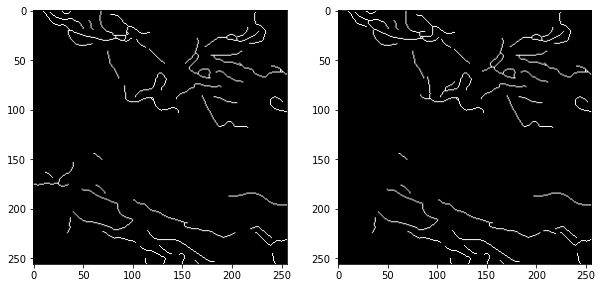

In [17]:
### any two centerline masks
image_1 = io.imread('Michael.tif')
image_2 = io.imread('Bin.tif')
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image_1, cmap='gray')
ax[1].imshow(image_2, cmap='gray')

0.9228023152549197


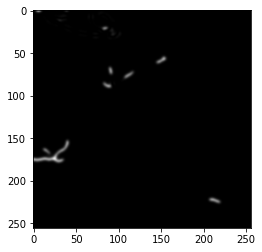

In [18]:
### Pixel-level metrics, soft IoU
ratio, U, I = iou(smooth_mask(image_1), smooth_mask(image_2), soft=True)
plt.imshow(U-I, cmap='gray')
print(np.sum(I)/np.sum(U))

In [ ]:
### cosine similarity of the features, maybe need to normalize each feature throughout the testing set